In [24]:
import numpy as np
import pandas as pd
from torch import nn
from torch import optim
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.decomposition

from lib.data_preprocessing import remove_correlated_columns, normalize_data
from lib.ds.bird_classes import NUM_CLASSES
from lib.ds.dataset_loading import load_all_data, flatten
from lib.ds.dataset_splitting import split
from lib.ds.torch_dataset import create_data_loader
from lib.model.attention_classifier import AttentionClassifier, AttentionClassifierHyperParameters
from lib.attention_classifier_training import train_attention_classifier_with_cv, train_attention_classifier, evaluate_attention_classifier
from lib.training_hyper_parameters import TrainingHyperParameters
from lib.ds.numpy_dataset import NumpyDataset
from lib.model.model_persistence import save_model, load_model
from lib.random import set_random_seed
from lib.metrics import calculate_average_metrics_for_final_epoch_of_folds, calculate_average_metrics_per_epoch
import lib.torch_device as tdev

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# tdev.PREFERRED = 'cpu'
device = tdev.get_torch_device()
device

device(type='cuda', index=0)

In [32]:
data_train_raw, labels_train, data_test_raw, labels_test = split(*load_all_data('dataset'), seed=69421)
print(f'{data_train.shape}')
print(f'{labels_train.shape}')
print(f'{data_test.shape}')
print(f'{labels_test.shape}')

(240, 100, 50)
(960, 100)
(240, 100, 264)
(240, 100)


In [18]:
# data_train, data_test = remove_correlated_columns(data_train, data_test)

print(f'{data_train.shape}')
print(f'{data_test.shape}')

(960, 100, 264)
(240, 100, 264)


In [38]:
N_COMPONENTS = 50

data_train_raw_shape = data_train_raw.shape
data_test_raw_shape = data_test_raw.shape

data_train_flat = data_train_raw.reshape(-1, data_train_raw.shape[-1])
data_test_flat = data_test_raw.reshape(-1, data_test_raw.shape[-1])

pca = sklearn.decomposition.PCA(n_components=N_COMPONENTS)
pca.fit(data_train_flat)

data_train_downprojected = pca.transform(data_train_flat)
data_test_downprojected = pca.transform(data_test_flat)

data_train = np.reshape(data_train_downprojected, (data_train_raw_shape[0], data_train_raw_shape[1], N_COMPONENTS))
data_test = np.reshape(data_test_downprojected, (data_test_raw_shape[0], data_test_raw_shape[1], N_COMPONENTS))

print(f'{data_train.shape}')
print(f'{data_test.shape}')

(960, 100, 50)
(240, 100, 50)


In [34]:
set_random_seed(42)
subset_indices = [
    bird * data_train.shape[0] // 6 + sample_nr
    for bird in range(6)
    for sample_nr in range(10)
]
# data_train_subset = data_train[subset_indices, :, :]
# labels_train_subset = labels_train[subset_indices, :]
data_train_subset = data_train[subset_indices, :, :]
labels_train_subset = labels_train[subset_indices, :]
print(data_train_subset.shape)
print(labels_train_subset.shape)

(60, 100, 50)
(60, 100)


# Hyper Parameters

In [39]:
hyper_parameters = AttentionClassifierHyperParameters(
    in_features=data_train.shape[-1],
    out_features=NUM_CLASSES,
    
    self_attention=True,
    d_model=60,
    num_heads=12,
    stack_size=1,
    attention_dropout=0.1,
    
    in_linear_hidden_out_features=[48, 48],
    out_linear_hidden_out_features=[64],
    linear_activation_provider=lambda: nn.LeakyReLU(),
    linear_dropout=0.0,
)

In [44]:
def create_training_hyper_parameters(epoch_multiplier: float, lr_multiplier: float):
    return TrainingHyperParameters(
        batch_size=32,

        optimizer_provider=lambda model, lr: optim.Adamax(
            model.parameters(),
            lr=lr,
            betas=(0.9, 0.98),
            eps=1e-9
        ),

        num_epochs=int(100 * epoch_multiplier),
        
        lr=1e-2 * lr_multiplier,
        lr_scheduler_milestones=[int(m * epoch_multiplier) for m in [10, 20, 40, 60, 80]],
        lr_scheduler_gamma=0.5,
        lr_scheduler_provider=lambda optimizer, milestones, gamma: lr_scheduler.MultiStepLR(
            optimizer, 
            milestones=milestones,
            gamma=gamma
        )
    )

# Training

## Cross Validation

Training fold 0
Training AttentionClassifier with 26739 parameters
loss_weight = tensor([ 1.0000, 15.8275,  9.6494, 10.6295, 36.9184, 17.7606, 19.8364],
       device='cuda:0')
Training Epoch   1/100: lr = 0.01, avg_loss = 0.000498, num_samples = 86400, num_correct =  8032, acc = 0.092963, bacc = 0.240717
Evaluation Epoch   1/100: avg_loss = 0.075897, num_samples =  9600, num_correct =  1264, acc = 0.131667, bacc = 0.320795
Training Epoch   2/100: lr = 0.01, avg_loss = 0.000411, num_samples = 86400, num_correct = 11156, acc = 0.129120, bacc = 0.357358
Evaluation Epoch   2/100: avg_loss = 0.071556, num_samples =  9600, num_correct =  2066, acc = 0.215208, bacc = 0.507917
Training Epoch   3/100: lr = 0.01, avg_loss = 0.000314, num_samples = 86400, num_correct = 18622, acc = 0.215532, bacc = 0.575373
Evaluation Epoch   3/100: avg_loss = 0.118465, num_samples =  9600, num_correct =  2452, acc = 0.255417, bacc = 0.571043
Training Epoch   4/100: lr = 0.01, avg_loss = 0.000259, num_samples = 

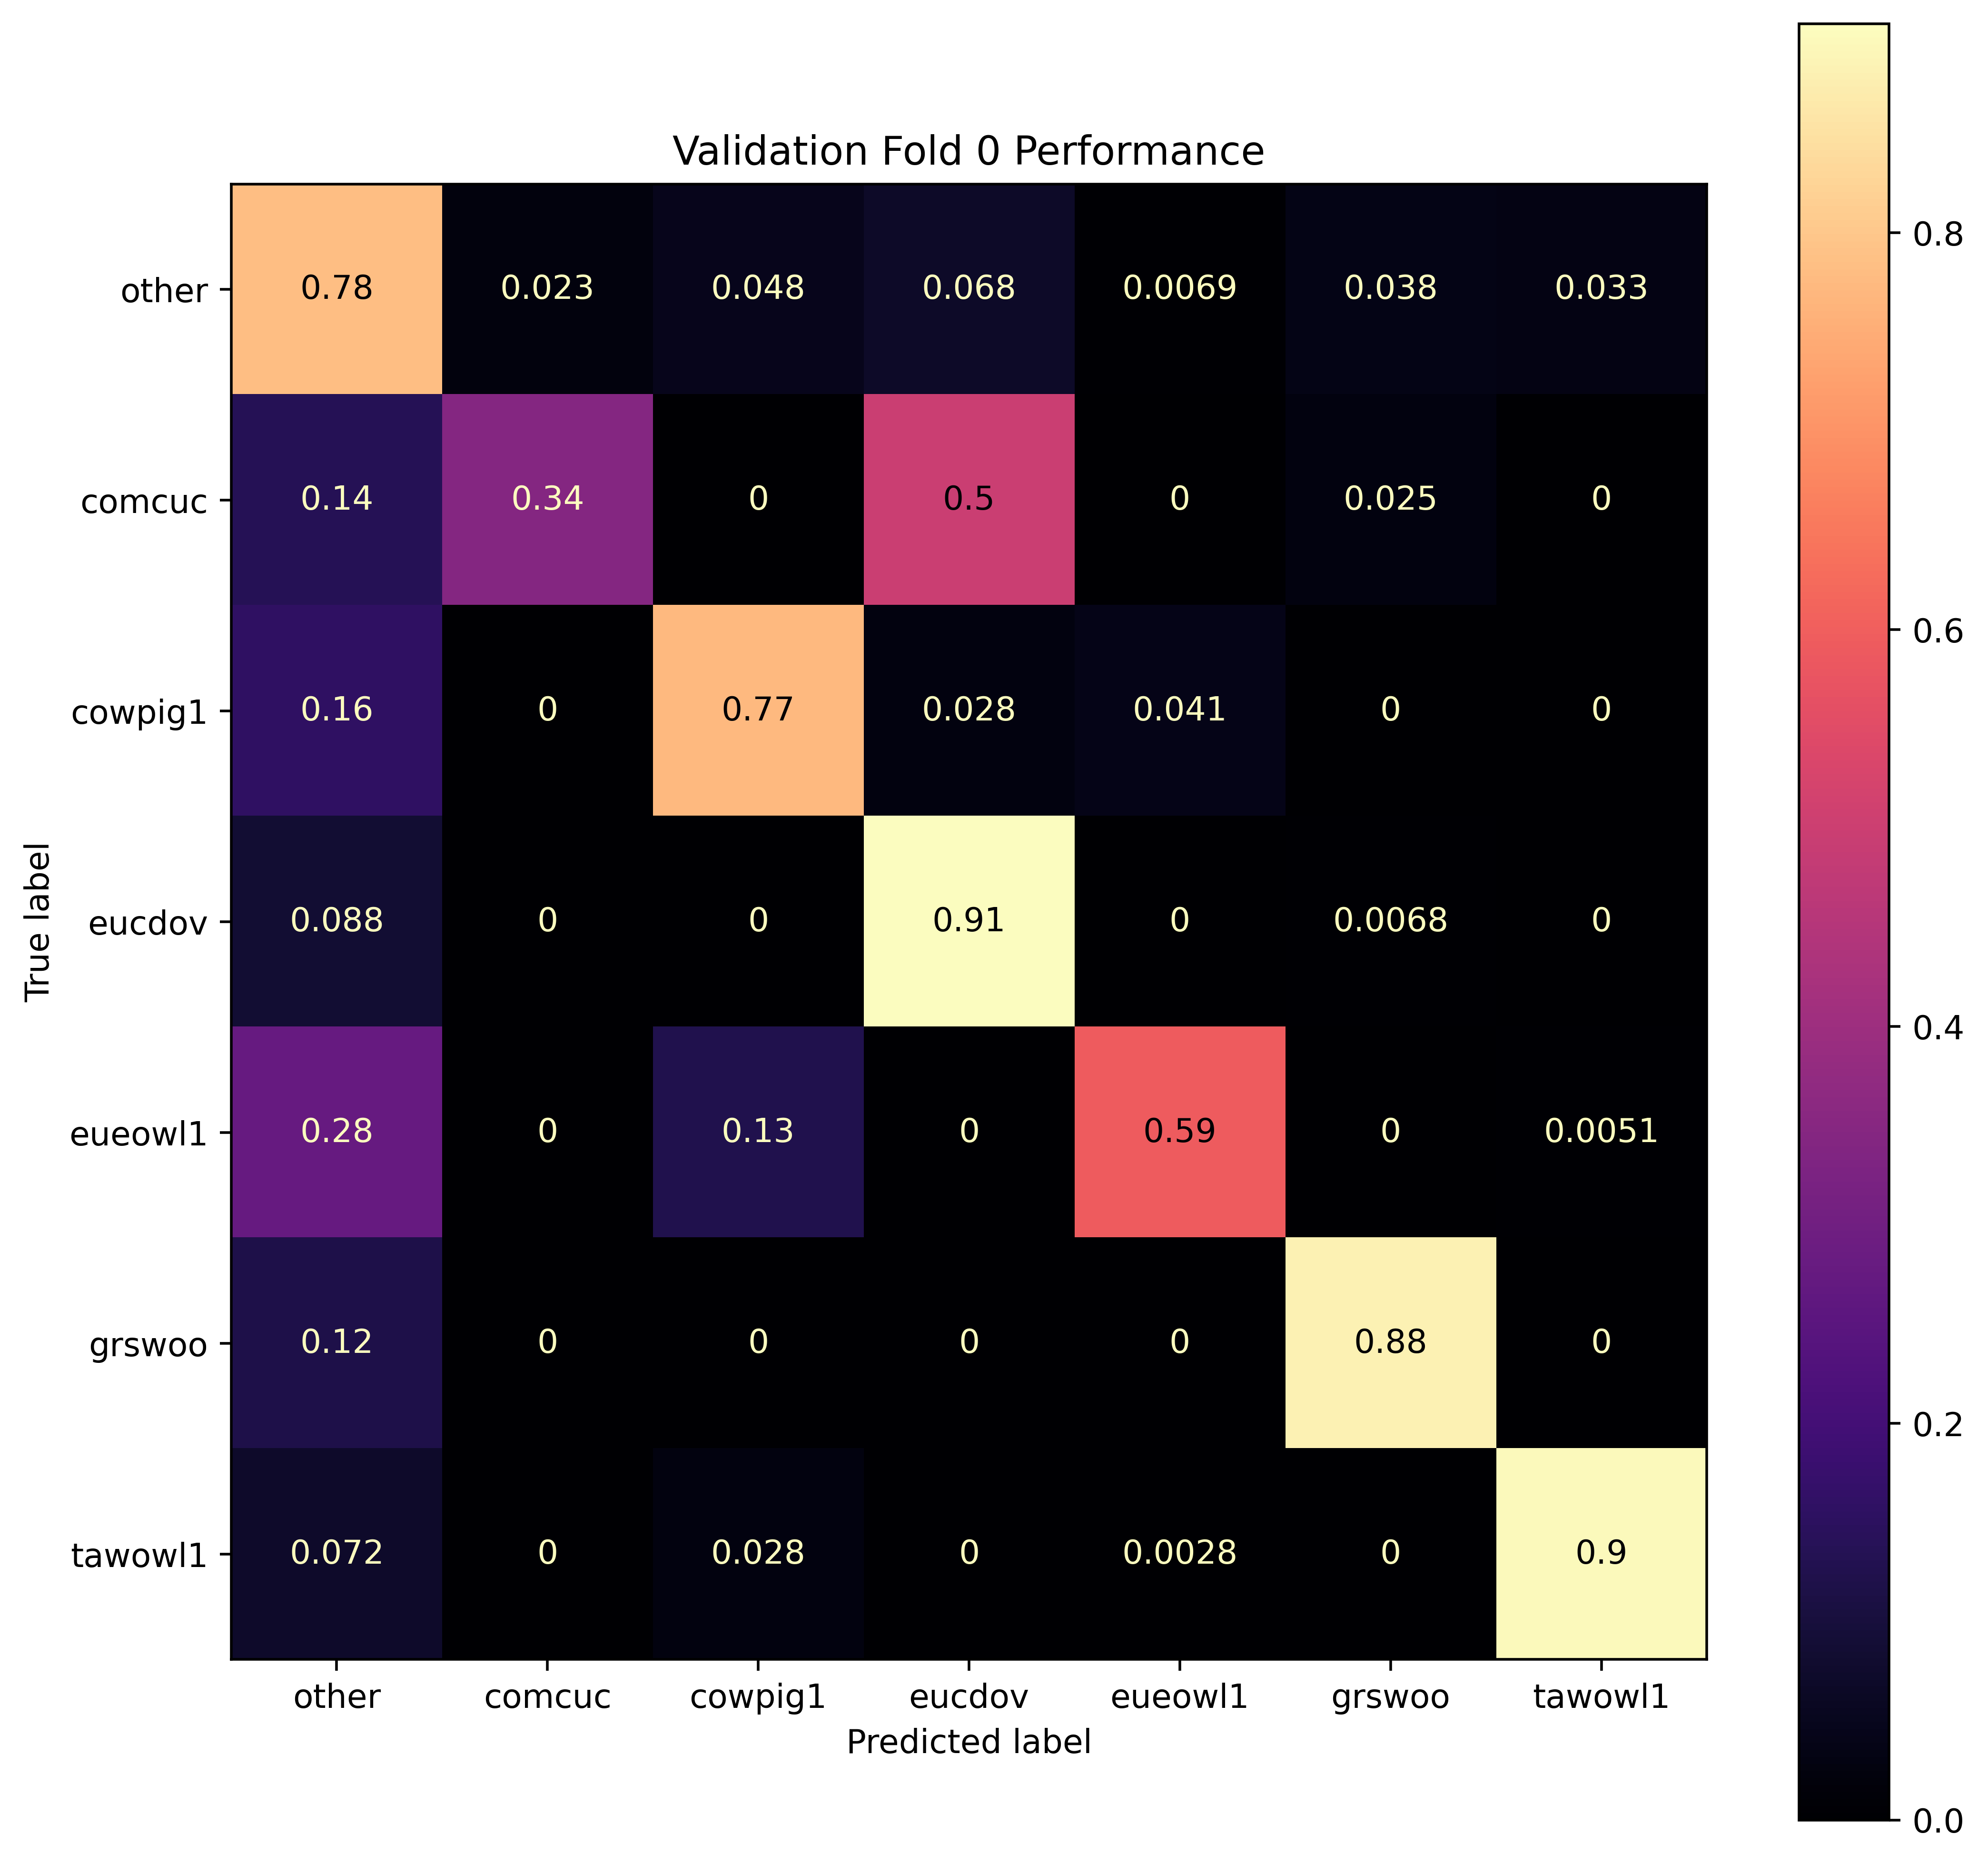

Saved model with scaler as "attention_classifier cv2023-05-18_21.34 fold-0"
Training fold 1
Training AttentionClassifier with 26739 parameters
loss_weight = tensor([ 1.0000, 15.3660,  9.3527, 10.3101, 35.4703, 17.9944, 19.5368],
       device='cuda:0')
Training Epoch   1/100: lr = 0.01, avg_loss = 0.000515, num_samples = 86400, num_correct =  8483, acc = 0.098183, bacc = 0.176707
Evaluation Epoch   1/100: avg_loss = 0.000485, num_samples =  9600, num_correct =  1141, acc = 0.118854, bacc = 0.330613
Training Epoch   2/100: lr = 0.01, avg_loss = 0.000416, num_samples = 86400, num_correct =  9350, acc = 0.108218, bacc = 0.304853
Evaluation Epoch   2/100: avg_loss = 0.000499, num_samples =  9600, num_correct =  1446, acc = 0.150625, bacc = 0.317470
Training Epoch   3/100: lr = 0.01, avg_loss = 0.000372, num_samples = 86400, num_correct = 13471, acc = 0.155914, bacc = 0.456288
Evaluation Epoch   3/100: avg_loss = 0.000479, num_samples =  9600, num_correct =  1878, acc = 0.195625, bacc = 0.4

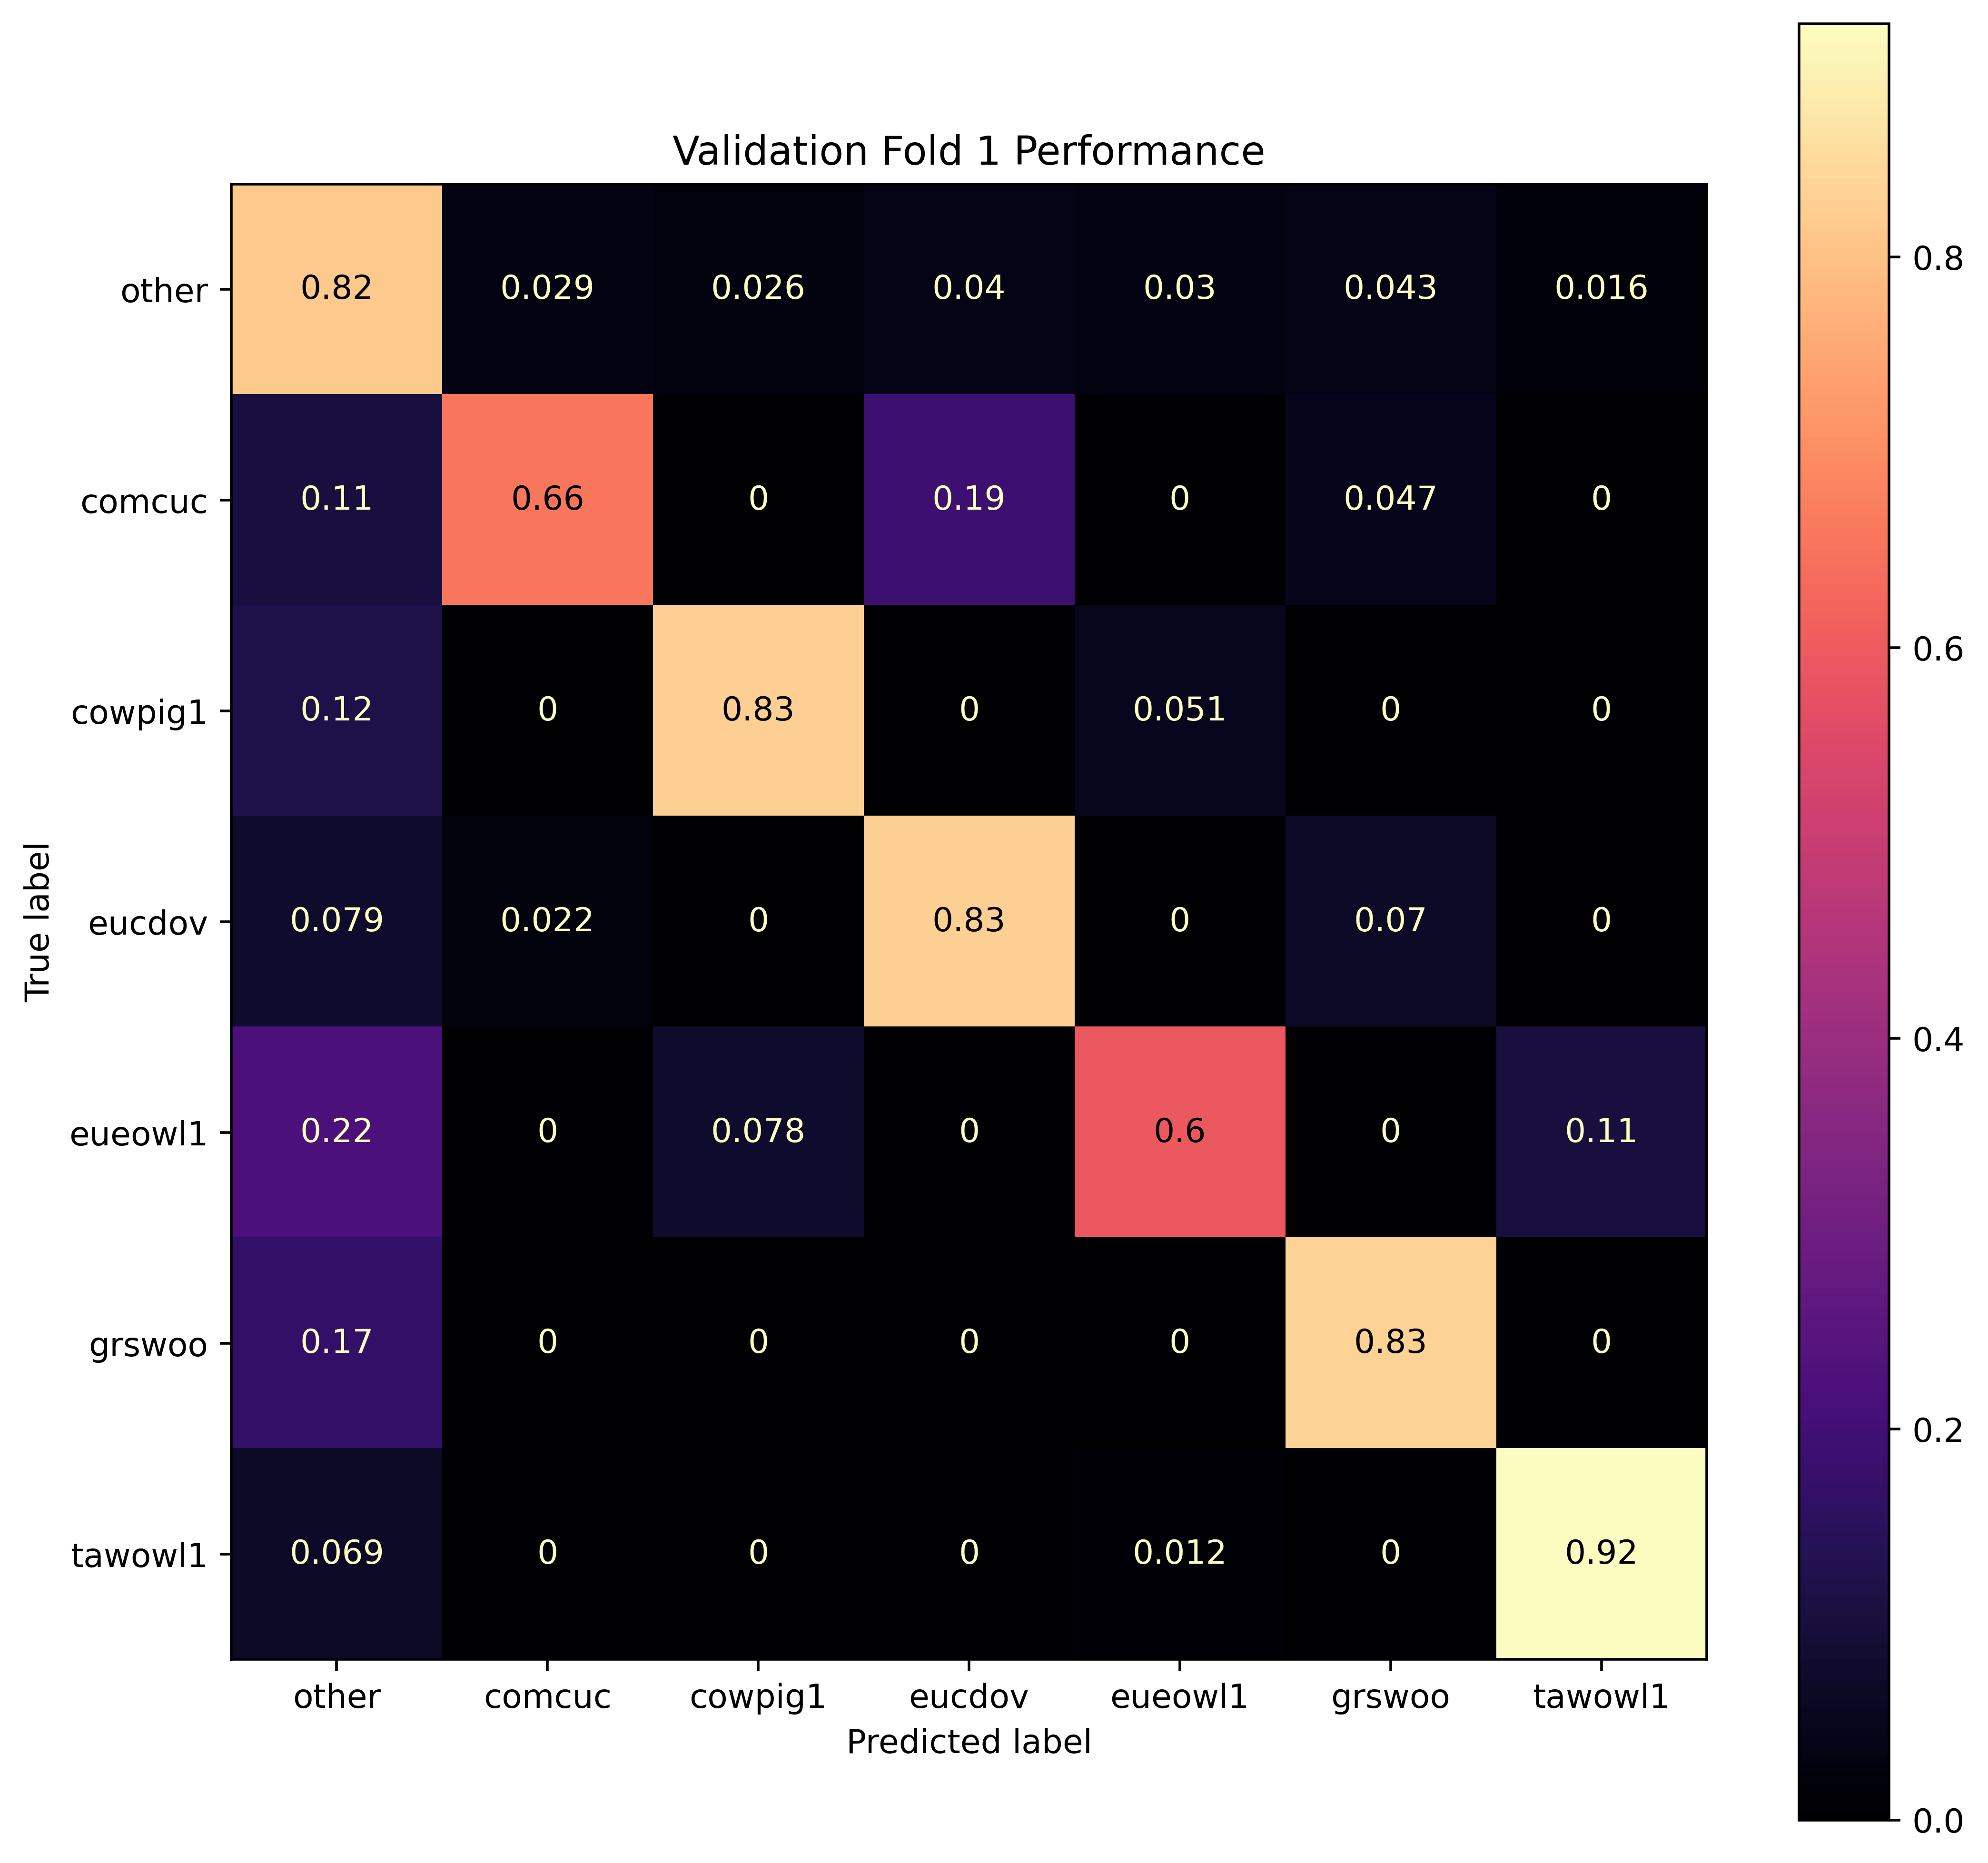

Saved model with scaler as "attention_classifier cv2023-05-18_21.34 fold-1"
Training fold 2
Training AttentionClassifier with 26739 parameters
loss_weight = tensor([ 1.0000, 15.2621,  9.1518, 10.3538, 36.6018, 18.4547, 19.1561],
       device='cuda:0')
Training Epoch   1/100: lr = 0.01, avg_loss = 0.000517, num_samples = 86400, num_correct =  6207, acc = 0.071840, bacc = 0.200368
Evaluation Epoch   1/100: avg_loss = 0.000465, num_samples =  9600, num_correct =  1035, acc = 0.107813, bacc = 0.296535
Training Epoch   2/100: lr = 0.01, avg_loss = 0.000427, num_samples = 86400, num_correct =  8222, acc = 0.095162, bacc = 0.265724
Evaluation Epoch   2/100: avg_loss = 0.000507, num_samples =  9600, num_correct =  1416, acc = 0.147500, bacc = 0.398071
Training Epoch   3/100: lr = 0.01, avg_loss = 0.000379, num_samples = 86400, num_correct = 14310, acc = 0.165625, bacc = 0.430252
Evaluation Epoch   3/100: avg_loss = 0.000505, num_samples =  9600, num_correct =  2268, acc = 0.236250, bacc = 0.5

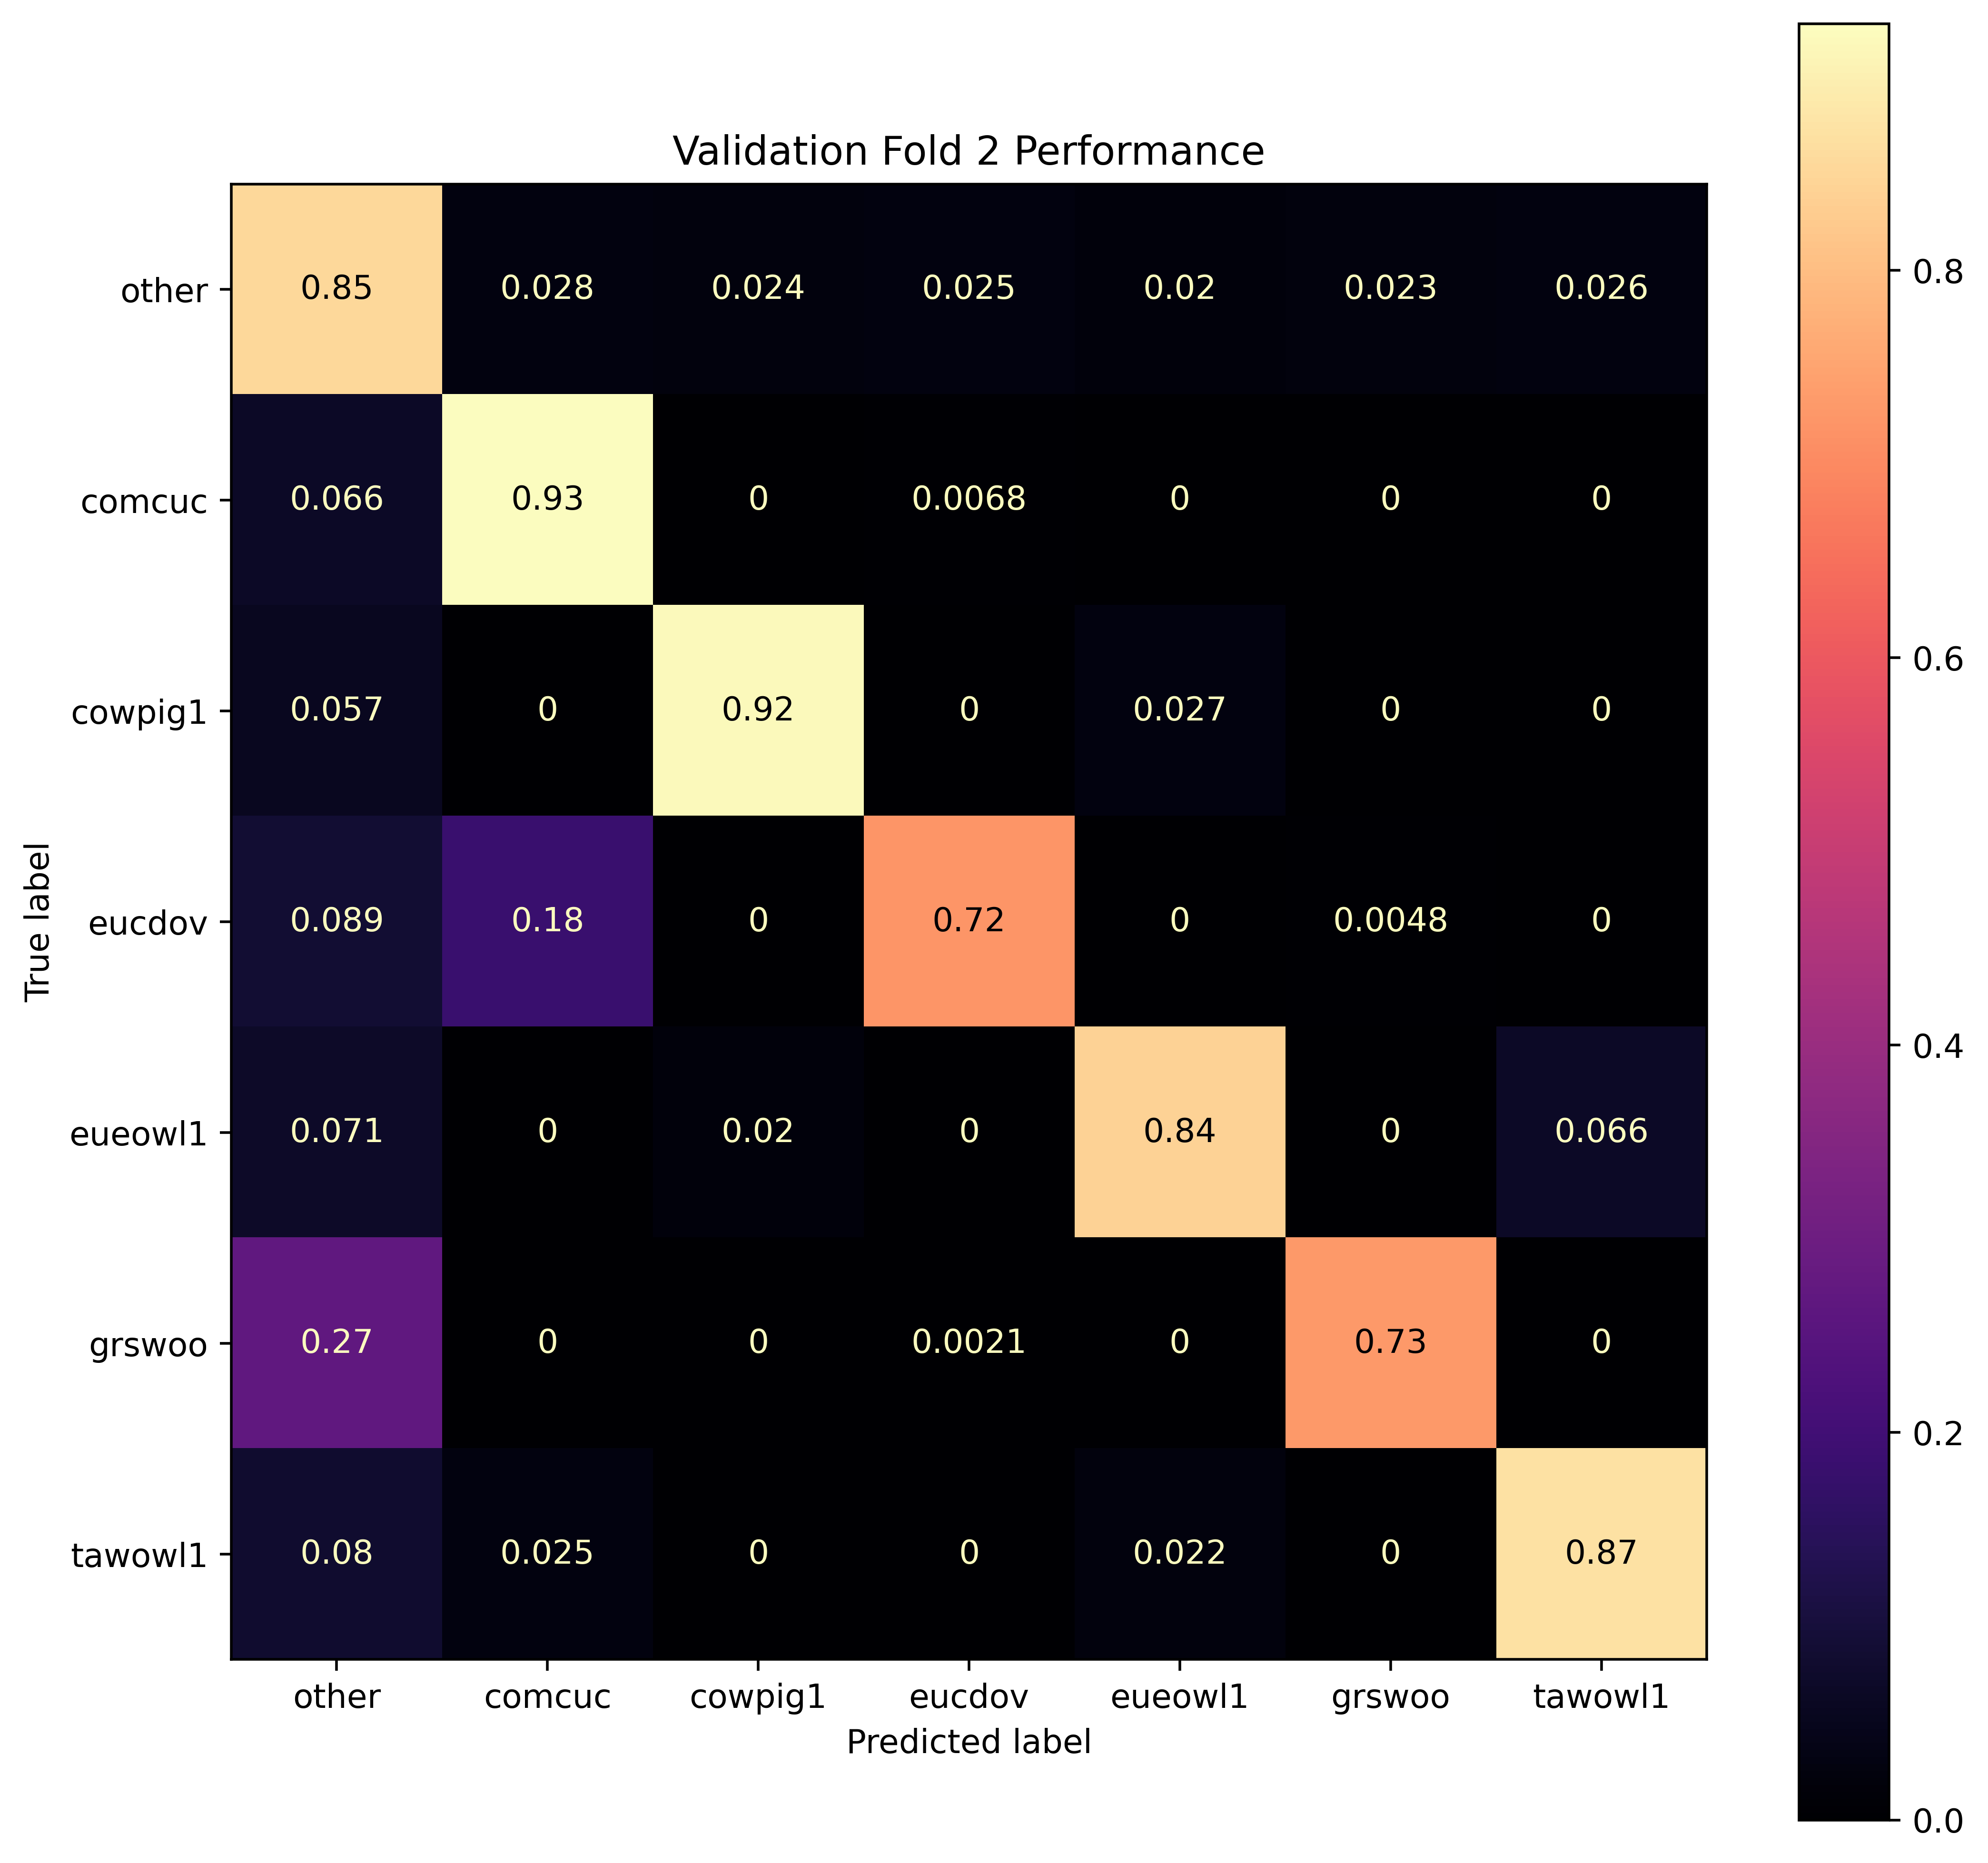

Saved model with scaler as "attention_classifier cv2023-05-18_21.34 fold-2"
Training fold 3
Training AttentionClassifier with 26739 parameters
loss_weight = tensor([ 1.0000, 15.5361,  9.3948, 10.4847, 38.6121, 18.1551, 19.8071],
       device='cuda:0')
Training Epoch   1/100: lr = 0.01, avg_loss = 0.000515, num_samples = 86400, num_correct =  8671, acc = 0.100359, bacc = 0.209483
Evaluation Epoch   1/100: avg_loss = 0.000474, num_samples =  9600, num_correct =  1383, acc = 0.144063, bacc = 0.344110
Training Epoch   2/100: lr = 0.01, avg_loss = 0.000411, num_samples = 86400, num_correct = 12588, acc = 0.145694, bacc = 0.334738
Evaluation Epoch   2/100: avg_loss = 0.000557, num_samples =  9600, num_correct =  1985, acc = 0.206771, bacc = 0.544828
Training Epoch   3/100: lr = 0.01, avg_loss = 0.000293, num_samples = 86400, num_correct = 20151, acc = 0.233229, bacc = 0.595734
Evaluation Epoch   3/100: avg_loss = 0.000432, num_samples =  9600, num_correct =  2905, acc = 0.302604, bacc = 0.7

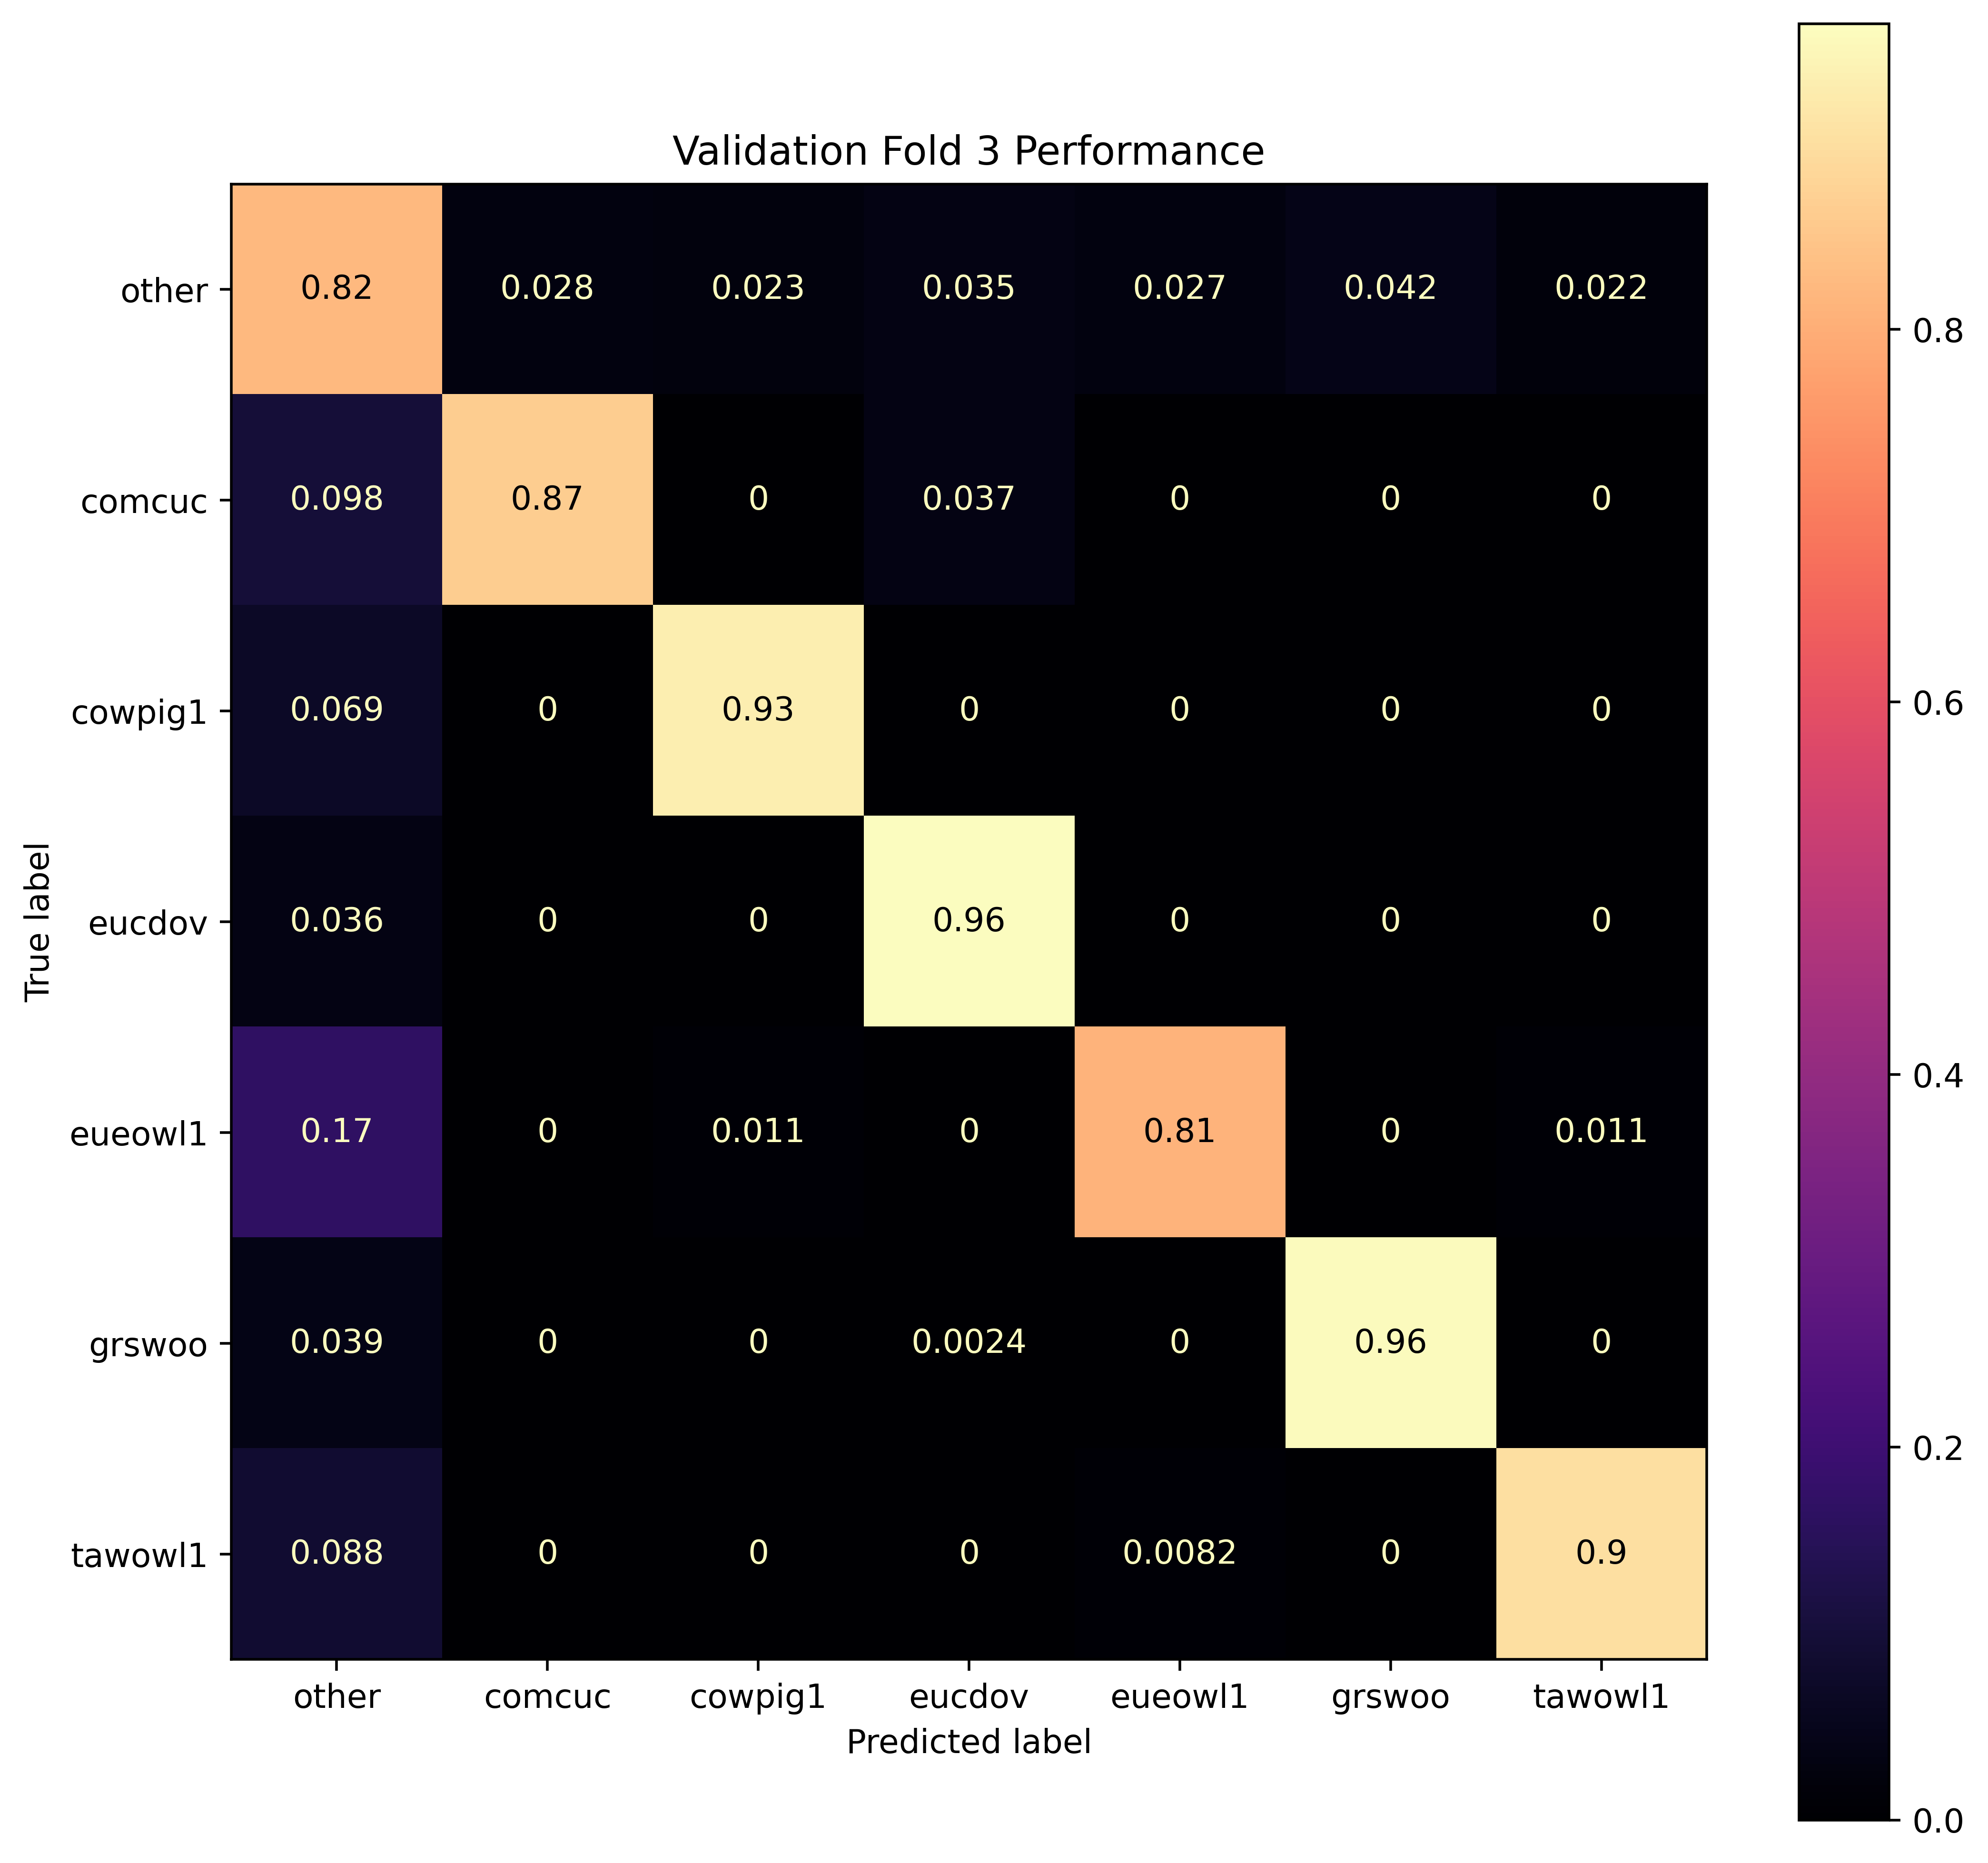

Saved model with scaler as "attention_classifier cv2023-05-18_21.34 fold-3"
Training fold 4
Training AttentionClassifier with 26739 parameters
loss_weight = tensor([ 1.0000, 15.1846,  9.1787, 10.5581, 36.7640, 17.6949, 19.7380],
       device='cuda:0')
Training Epoch   1/100: lr = 0.01, avg_loss = 0.000503, num_samples = 86400, num_correct =  9349, acc = 0.108206, bacc = 0.226892
Evaluation Epoch   1/100: avg_loss = 0.000479, num_samples =  9600, num_correct =  1111, acc = 0.115729, bacc = 0.273477
Training Epoch   2/100: lr = 0.01, avg_loss = 0.000435, num_samples = 86400, num_correct =  9245, acc = 0.107002, bacc = 0.311188
Evaluation Epoch   2/100: avg_loss = 0.000543, num_samples =  9600, num_correct =  1130, acc = 0.117708, bacc = 0.406226
Training Epoch   3/100: lr = 0.01, avg_loss = 0.000378, num_samples = 86400, num_correct = 11937, acc = 0.138160, bacc = 0.455989
Evaluation Epoch   3/100: avg_loss = 0.000469, num_samples =  9600, num_correct =  1391, acc = 0.144896, bacc = 0.5

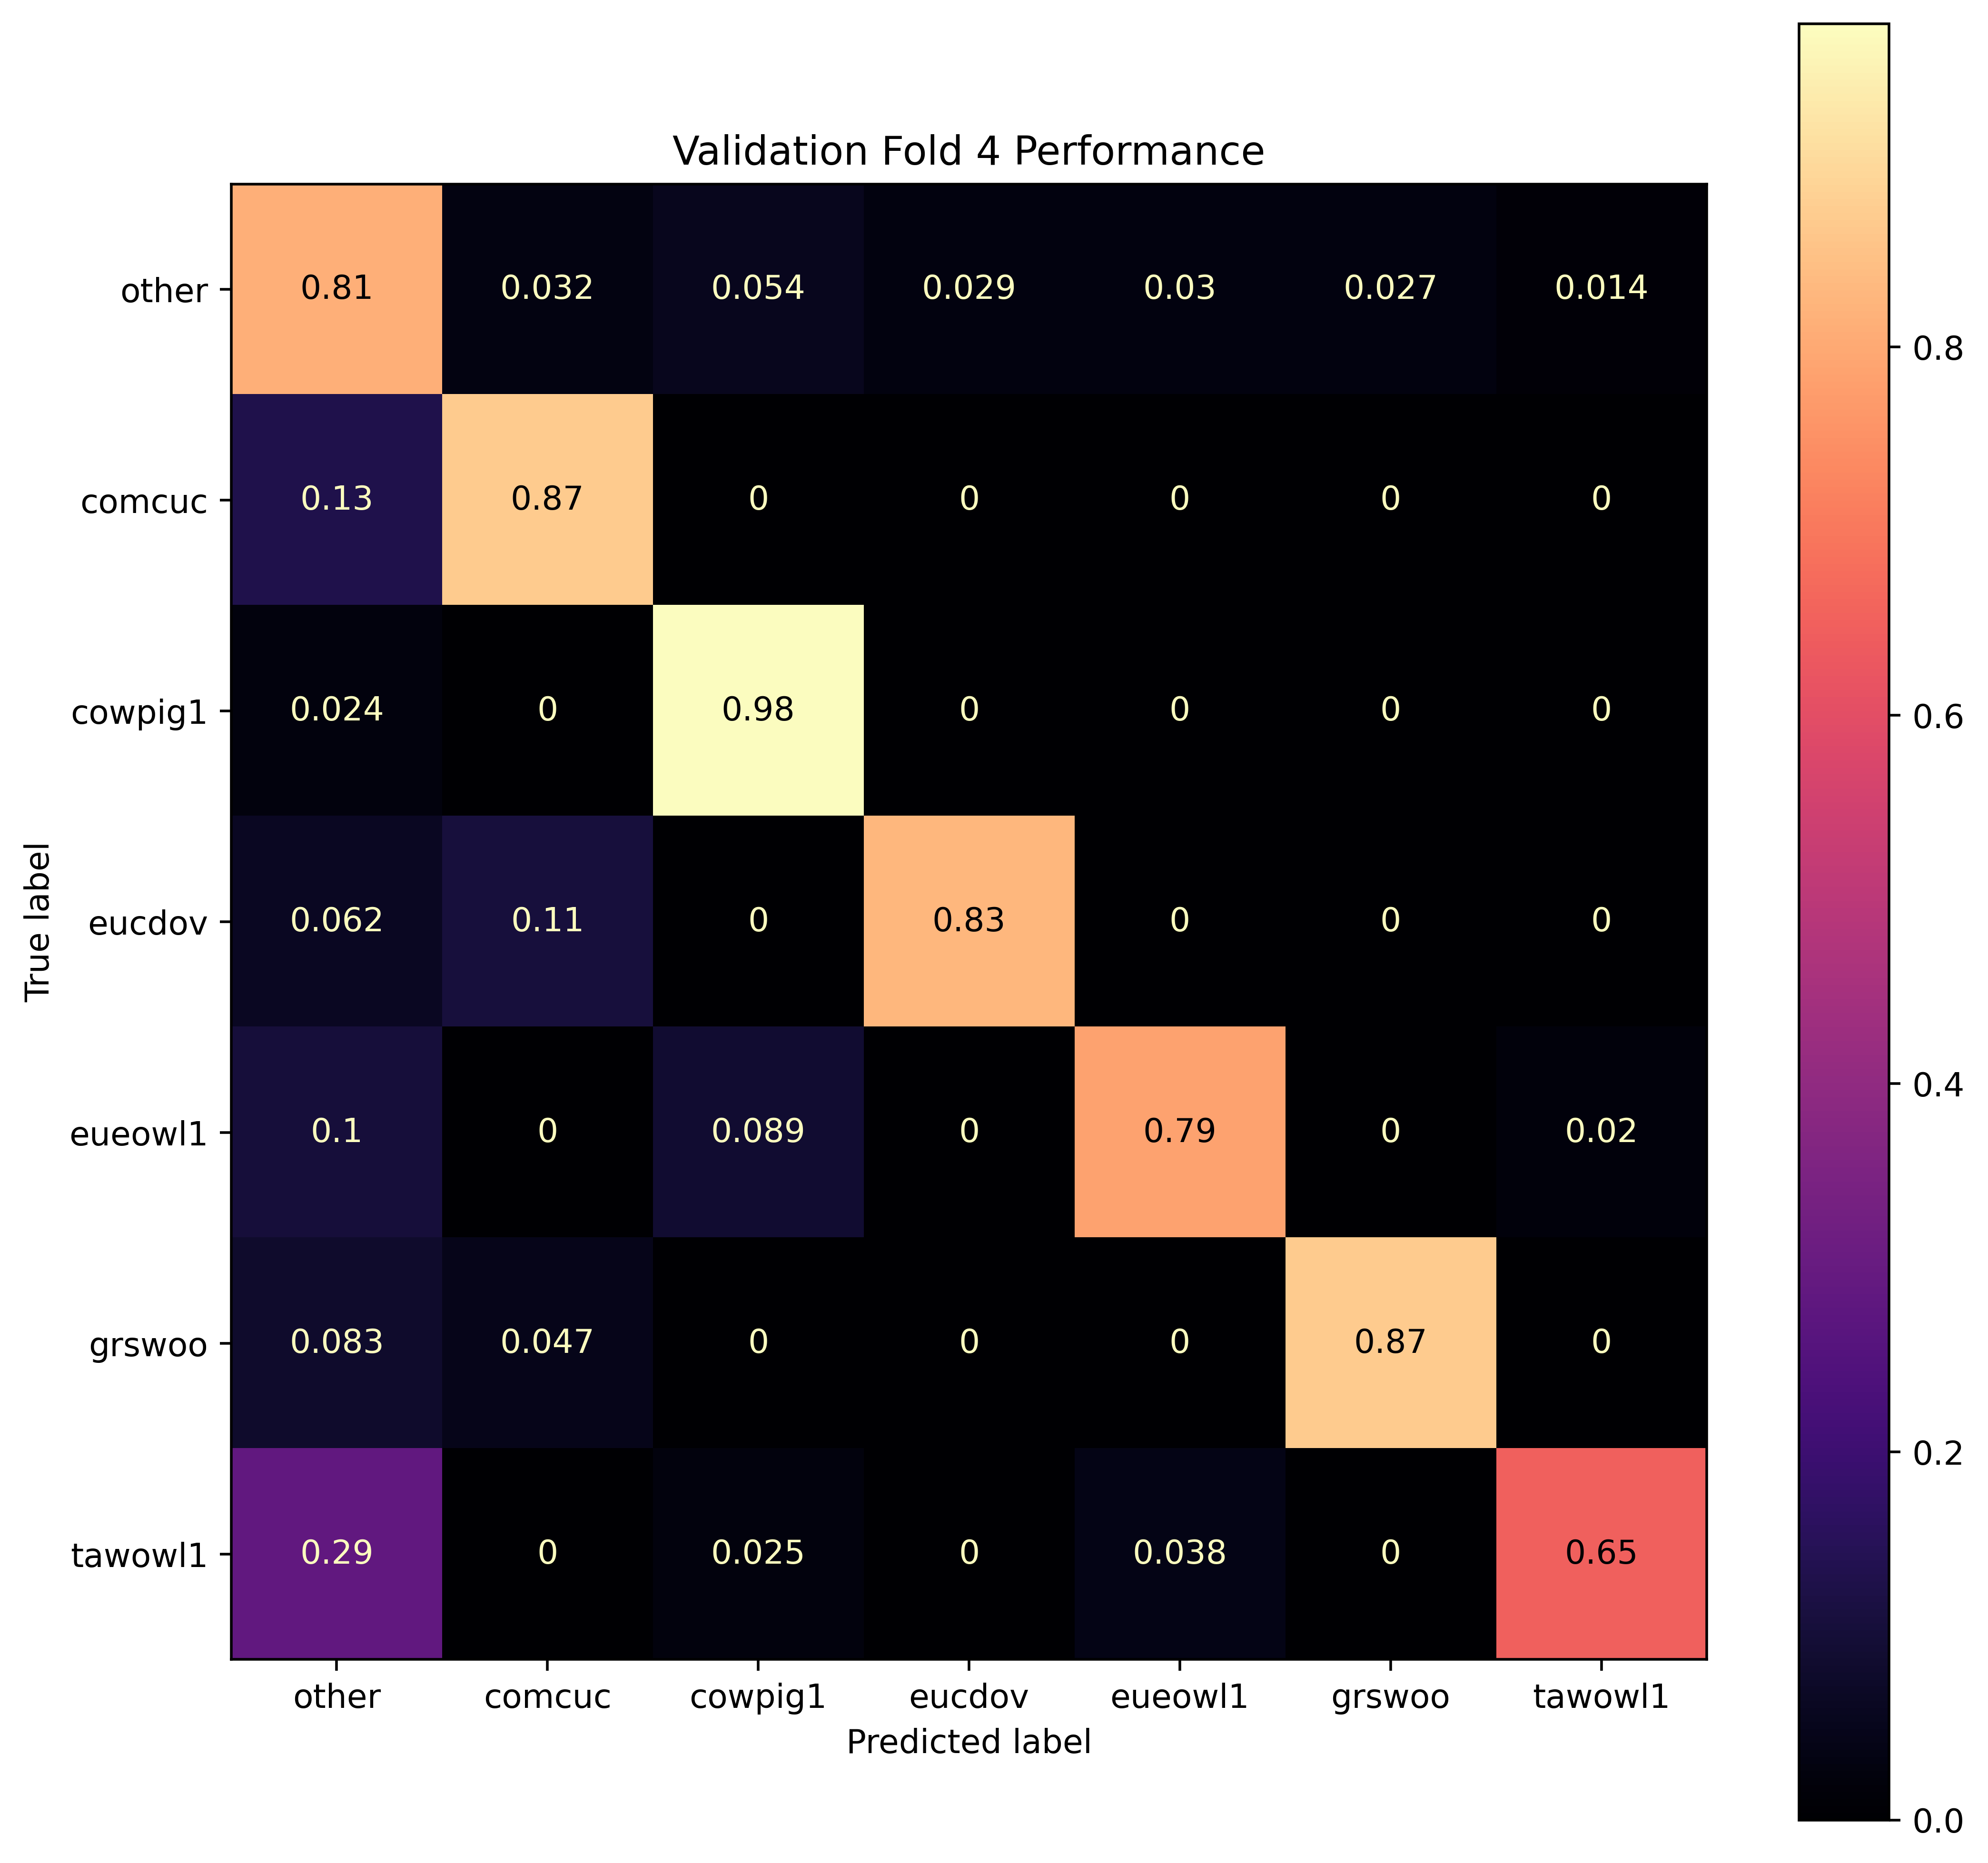

Saved model with scaler as "attention_classifier cv2023-05-18_21.34 fold-4"
Training fold 5
Training AttentionClassifier with 26739 parameters
loss_weight = tensor([ 1.0000, 15.1535,  9.3891, 10.5016, 34.7896, 17.2970, 19.8349],
       device='cuda:0')
Training Epoch   1/100: lr = 0.01, avg_loss = 0.000523, num_samples = 86400, num_correct =  5854, acc = 0.067755, bacc = 0.213228
Evaluation Epoch   1/100: avg_loss = 0.000482, num_samples =  9600, num_correct =  1298, acc = 0.135208, bacc = 0.261201
Training Epoch   2/100: lr = 0.01, avg_loss = 0.000431, num_samples = 86400, num_correct =  6993, acc = 0.080937, bacc = 0.243273
Evaluation Epoch   2/100: avg_loss = 0.000501, num_samples =  9600, num_correct =  1419, acc = 0.147813, bacc = 0.414679
Training Epoch   3/100: lr = 0.01, avg_loss = 0.000359, num_samples = 86400, num_correct = 16262, acc = 0.188218, bacc = 0.506946
Evaluation Epoch   3/100: avg_loss = 0.000496, num_samples =  9600, num_correct =  2335, acc = 0.243229, bacc = 0.5

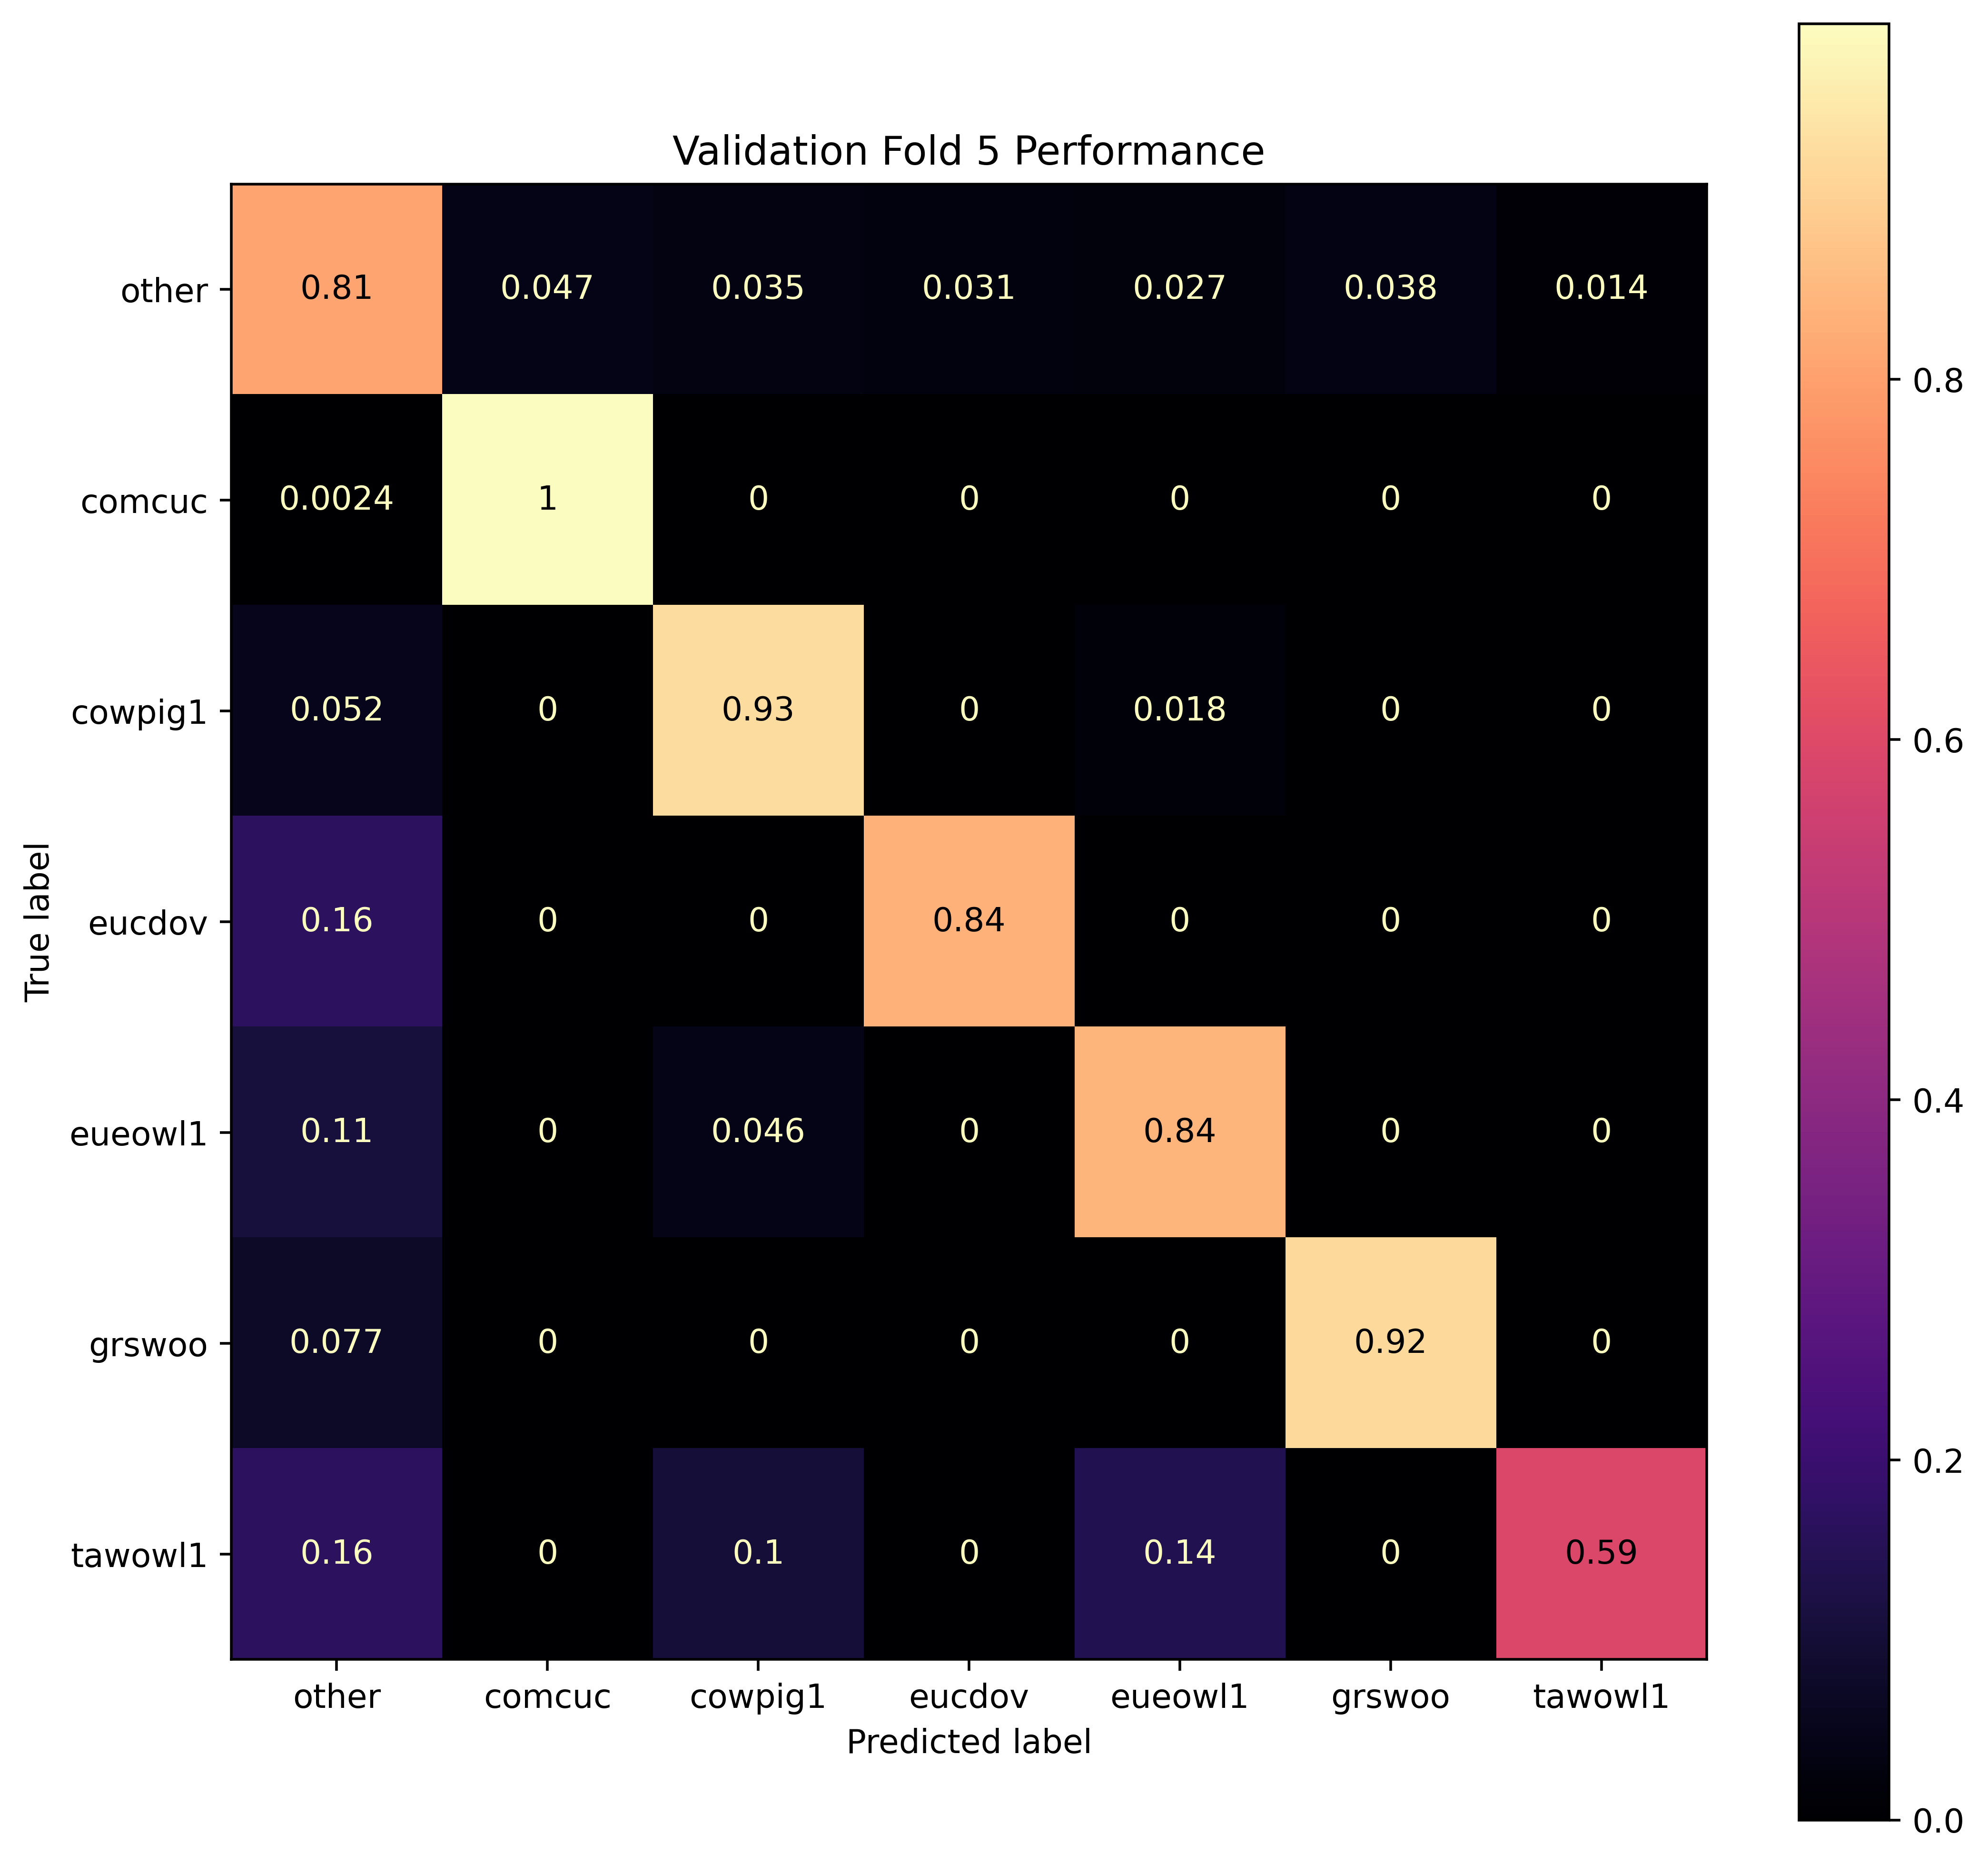

Saved model with scaler as "attention_classifier cv2023-05-18_21.34 fold-5"
Training fold 6
Training AttentionClassifier with 26739 parameters
loss_weight = tensor([ 1.0000, 15.5322,  9.7103, 10.4657, 37.7940, 18.6807, 19.9229],
       device='cuda:0')
Training Epoch   1/100: lr = 0.01, avg_loss = 0.000516, num_samples = 86400, num_correct =  6336, acc = 0.073333, bacc = 0.204033
Evaluation Epoch   1/100: avg_loss = 0.000481, num_samples =  9600, num_correct =  1226, acc = 0.127708, bacc = 0.326474
Training Epoch   2/100: lr = 0.01, avg_loss = 0.000420, num_samples = 86400, num_correct =  8369, acc = 0.096863, bacc = 0.324042
Evaluation Epoch   2/100: avg_loss = 0.000498, num_samples =  9600, num_correct =  1415, acc = 0.147396, bacc = 0.410864
Training Epoch   3/100: lr = 0.01, avg_loss = 0.000369, num_samples = 86400, num_correct = 12786, acc = 0.147986, bacc = 0.453901
Evaluation Epoch   3/100: avg_loss = 0.000487, num_samples =  9600, num_correct =  1855, acc = 0.193229, bacc = 0.5

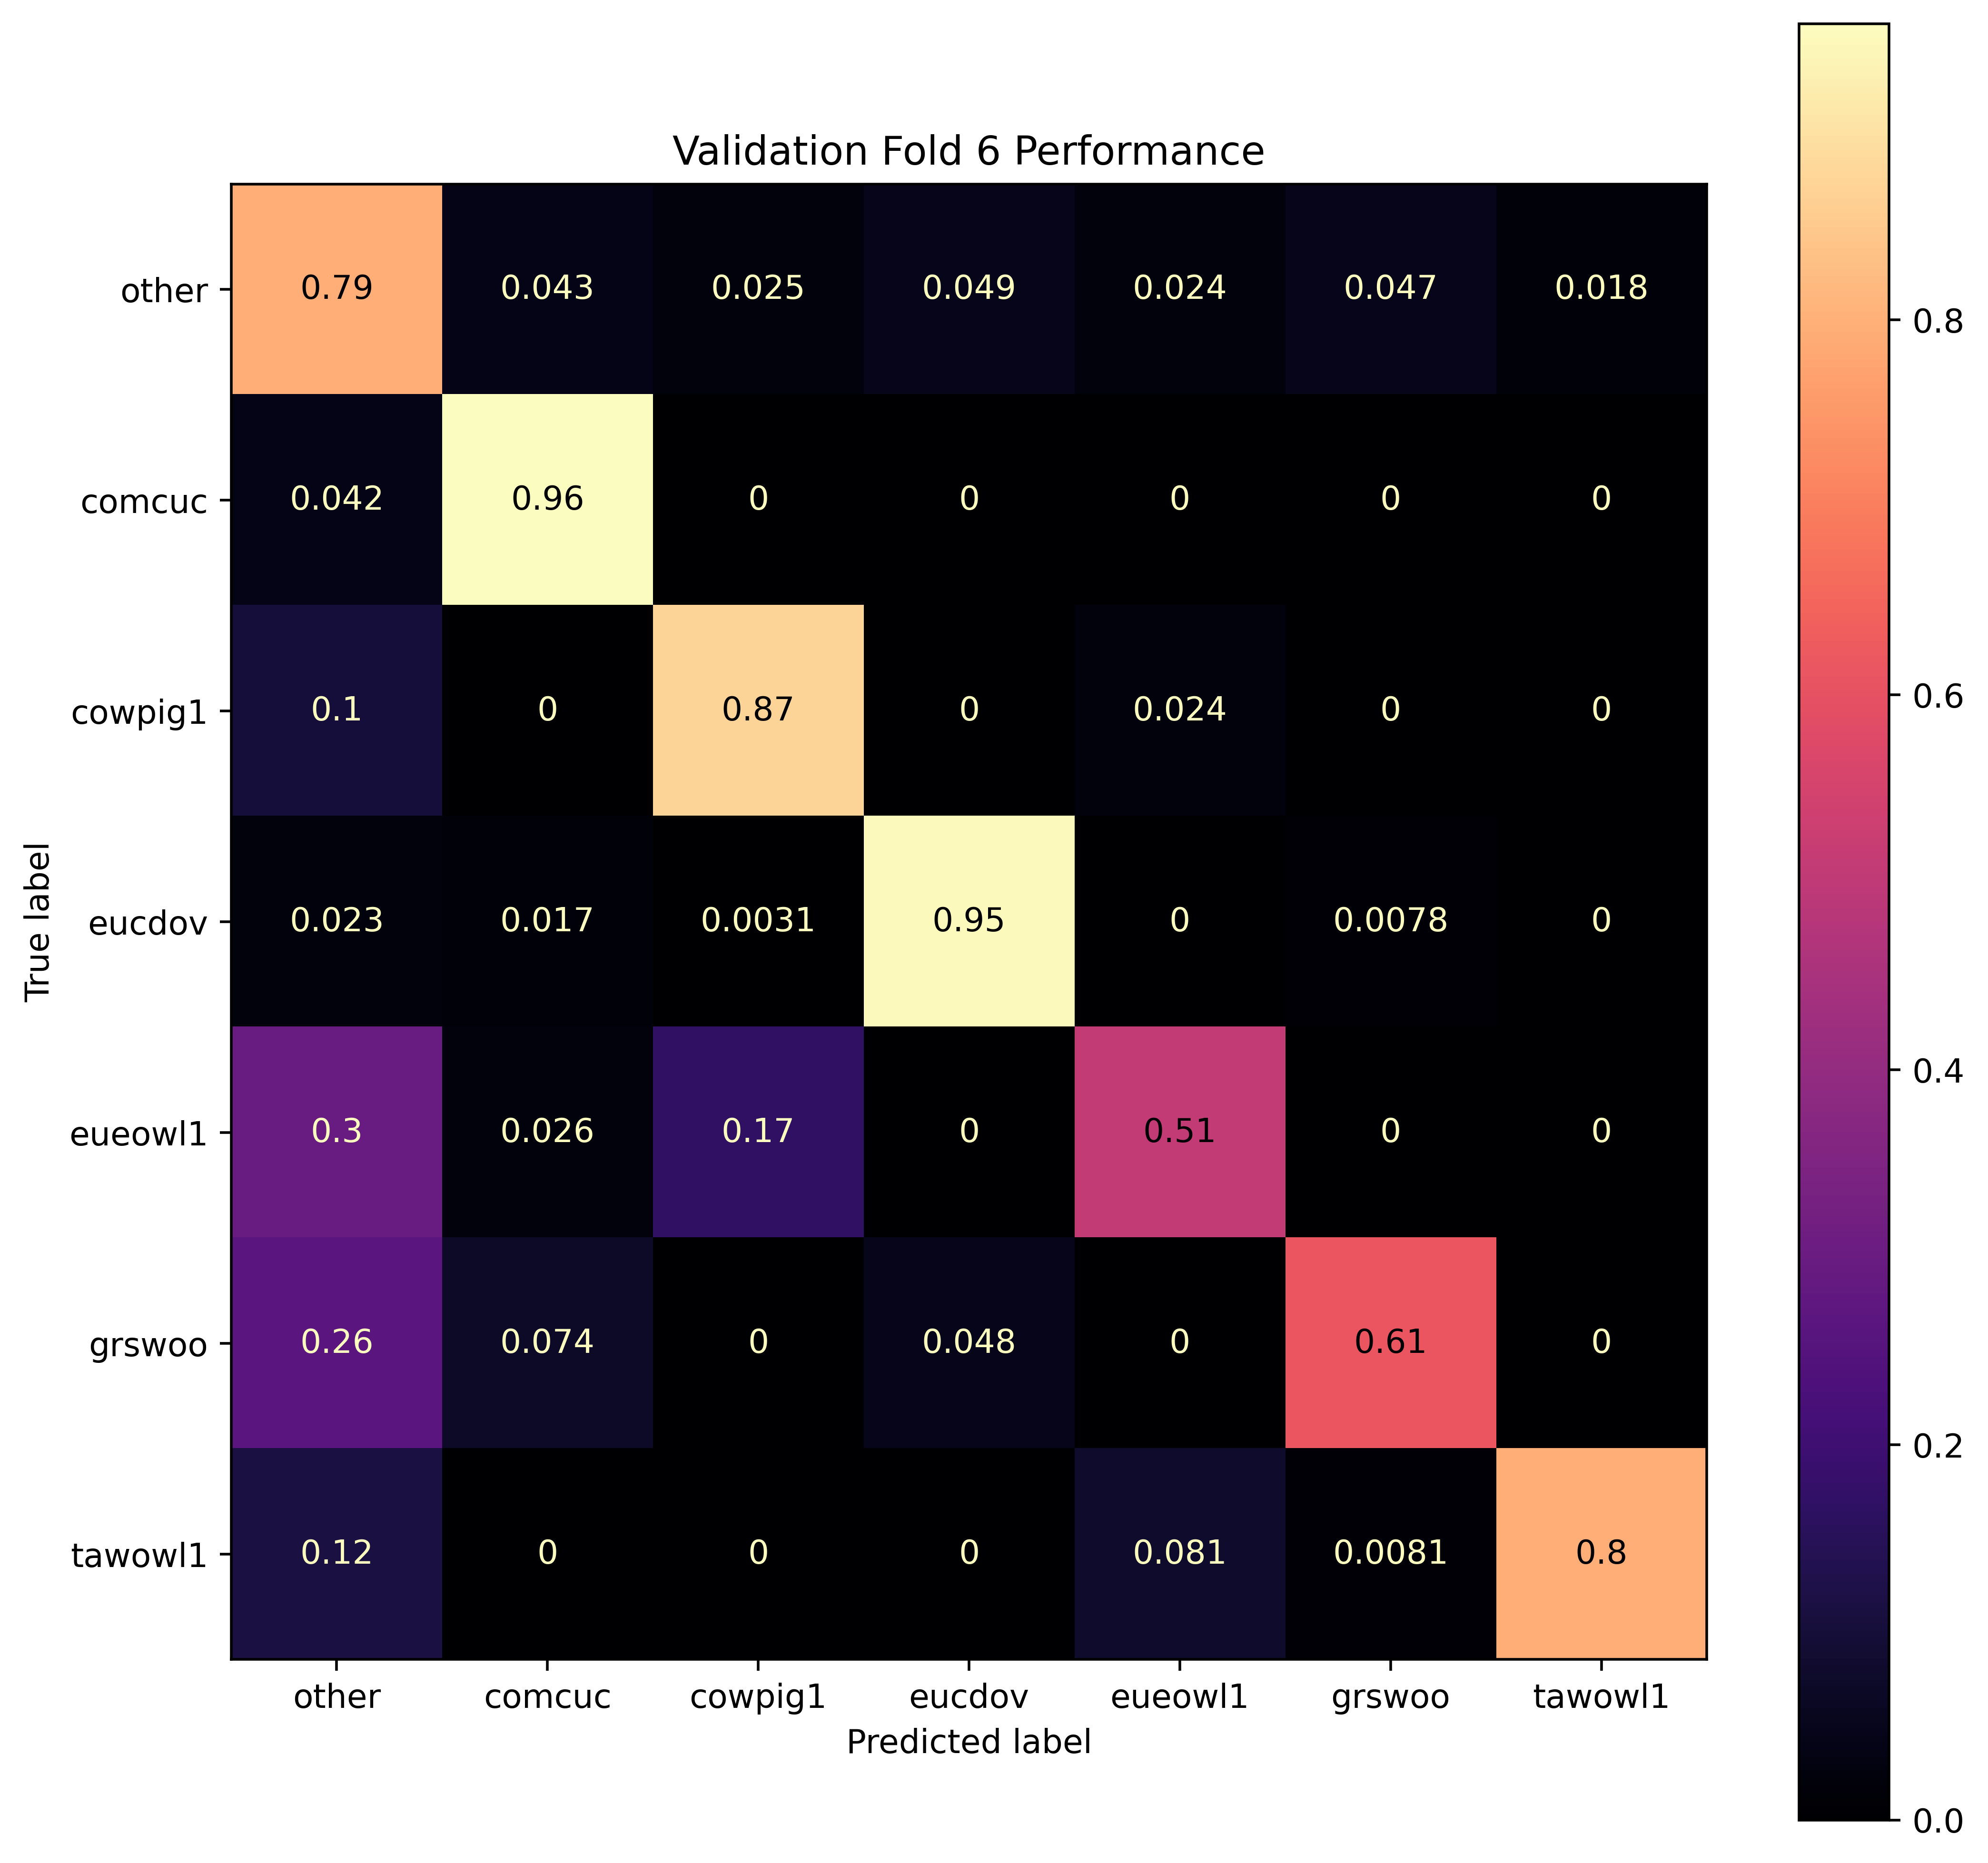

Saved model with scaler as "attention_classifier cv2023-05-18_21.34 fold-6"
Training fold 7
Training AttentionClassifier with 26739 parameters
loss_weight = tensor([ 1.0000, 15.2754,  9.2280, 10.5393, 36.0422, 17.5385, 19.9870],
       device='cuda:0')
Training Epoch   1/100: lr = 0.01, avg_loss = 0.000527, num_samples = 86400, num_correct = 15883, acc = 0.183831, bacc = 0.162579
Evaluation Epoch   1/100: avg_loss = 0.000558, num_samples =  9600, num_correct =   991, acc = 0.103229, bacc = 0.294776
Training Epoch   2/100: lr = 0.01, avg_loss = 0.000428, num_samples = 86400, num_correct =  7734, acc = 0.089514, bacc = 0.237375
Evaluation Epoch   2/100: avg_loss = 0.000512, num_samples =  9600, num_correct =  1916, acc = 0.199583, bacc = 0.502728
Training Epoch   3/100: lr = 0.01, avg_loss = 0.000374, num_samples = 86400, num_correct = 16728, acc = 0.193611, bacc = 0.478773
Evaluation Epoch   3/100: avg_loss = 0.000534, num_samples =  9600, num_correct =  2260, acc = 0.235417, bacc = 0.5

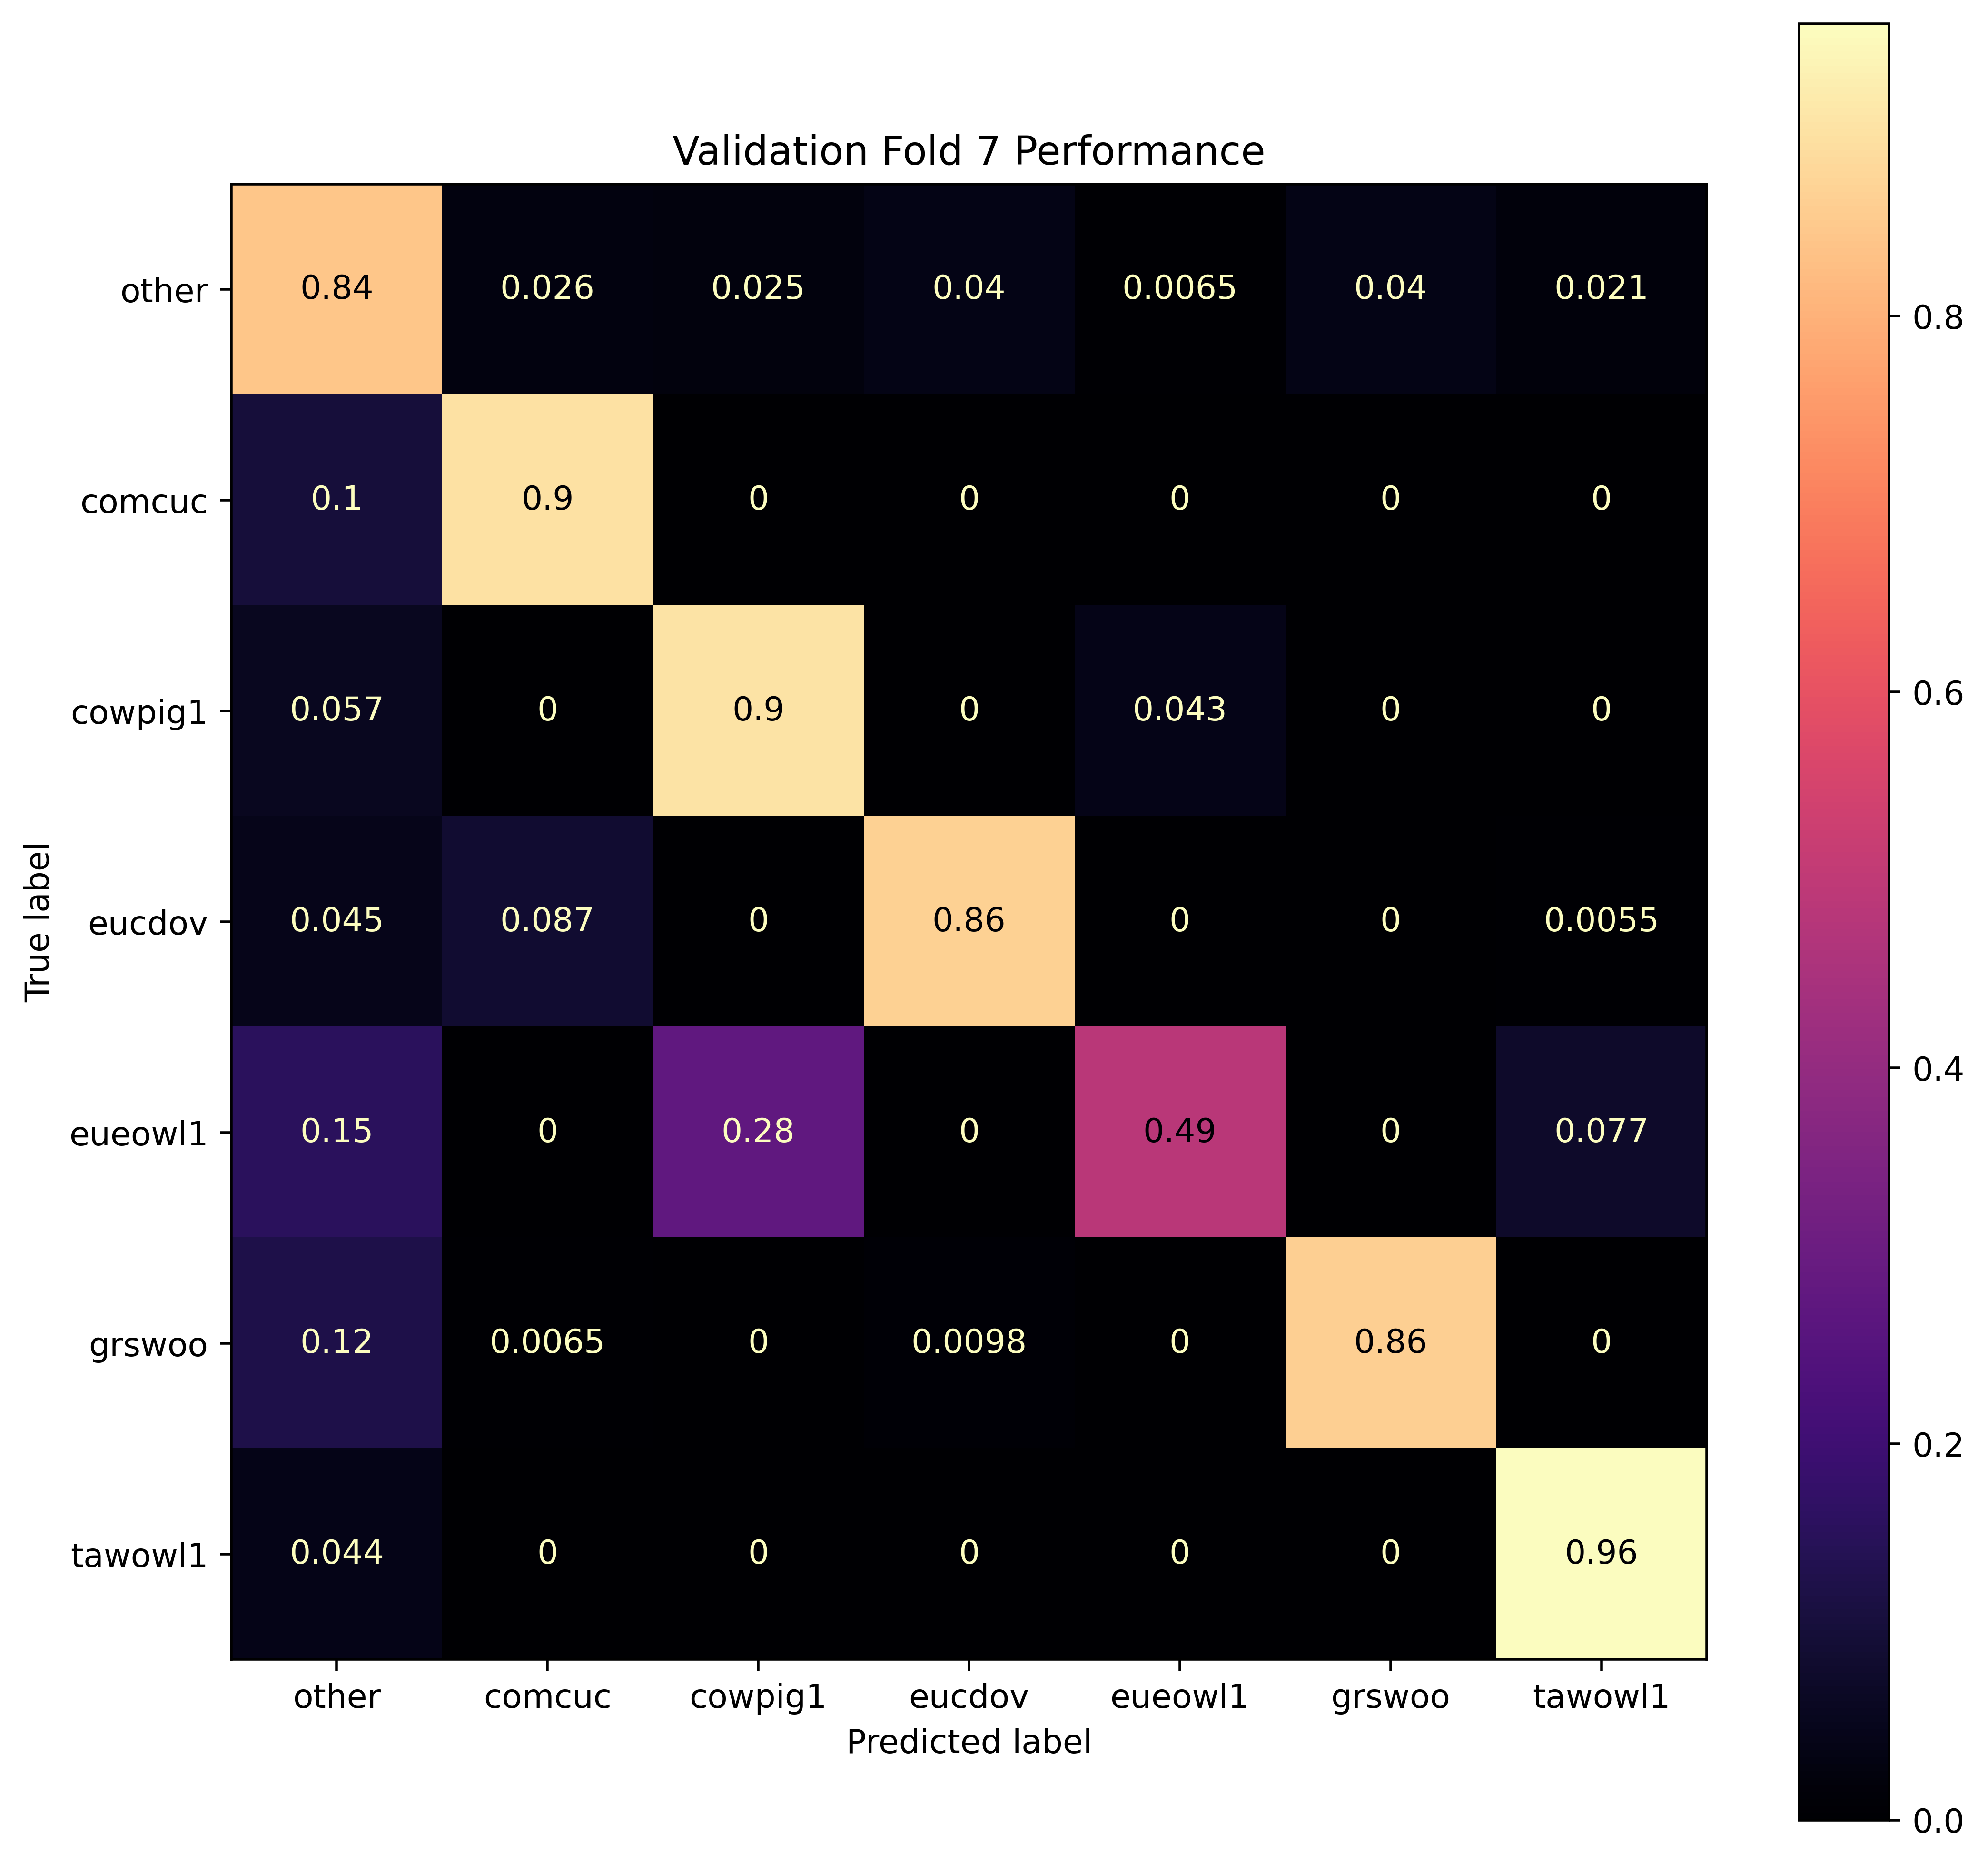

Saved model with scaler as "attention_classifier cv2023-05-18_21.34 fold-7"
Training fold 8
Training AttentionClassifier with 26739 parameters
loss_weight = tensor([ 1.0000, 14.8754,  9.0629, 10.1272, 34.8762, 17.6241, 19.4274],
       device='cuda:0')
Training Epoch   1/100: lr = 0.01, avg_loss = 0.000521, num_samples = 86400, num_correct =  5301, acc = 0.061354, bacc = 0.161389
Evaluation Epoch   1/100: avg_loss = 0.000526, num_samples =  9600, num_correct =  1264, acc = 0.131667, bacc = 0.352902
Training Epoch   2/100: lr = 0.01, avg_loss = 0.000432, num_samples = 86400, num_correct =  9218, acc = 0.106690, bacc = 0.327495
Evaluation Epoch   2/100: avg_loss = 0.000541, num_samples =  9600, num_correct =  1592, acc = 0.165833, bacc = 0.455973
Training Epoch   3/100: lr = 0.01, avg_loss = 0.000379, num_samples = 86400, num_correct = 13238, acc = 0.153218, bacc = 0.426707
Evaluation Epoch   3/100: avg_loss = 0.000528, num_samples =  9600, num_correct =  1545, acc = 0.160938, bacc = 0.4

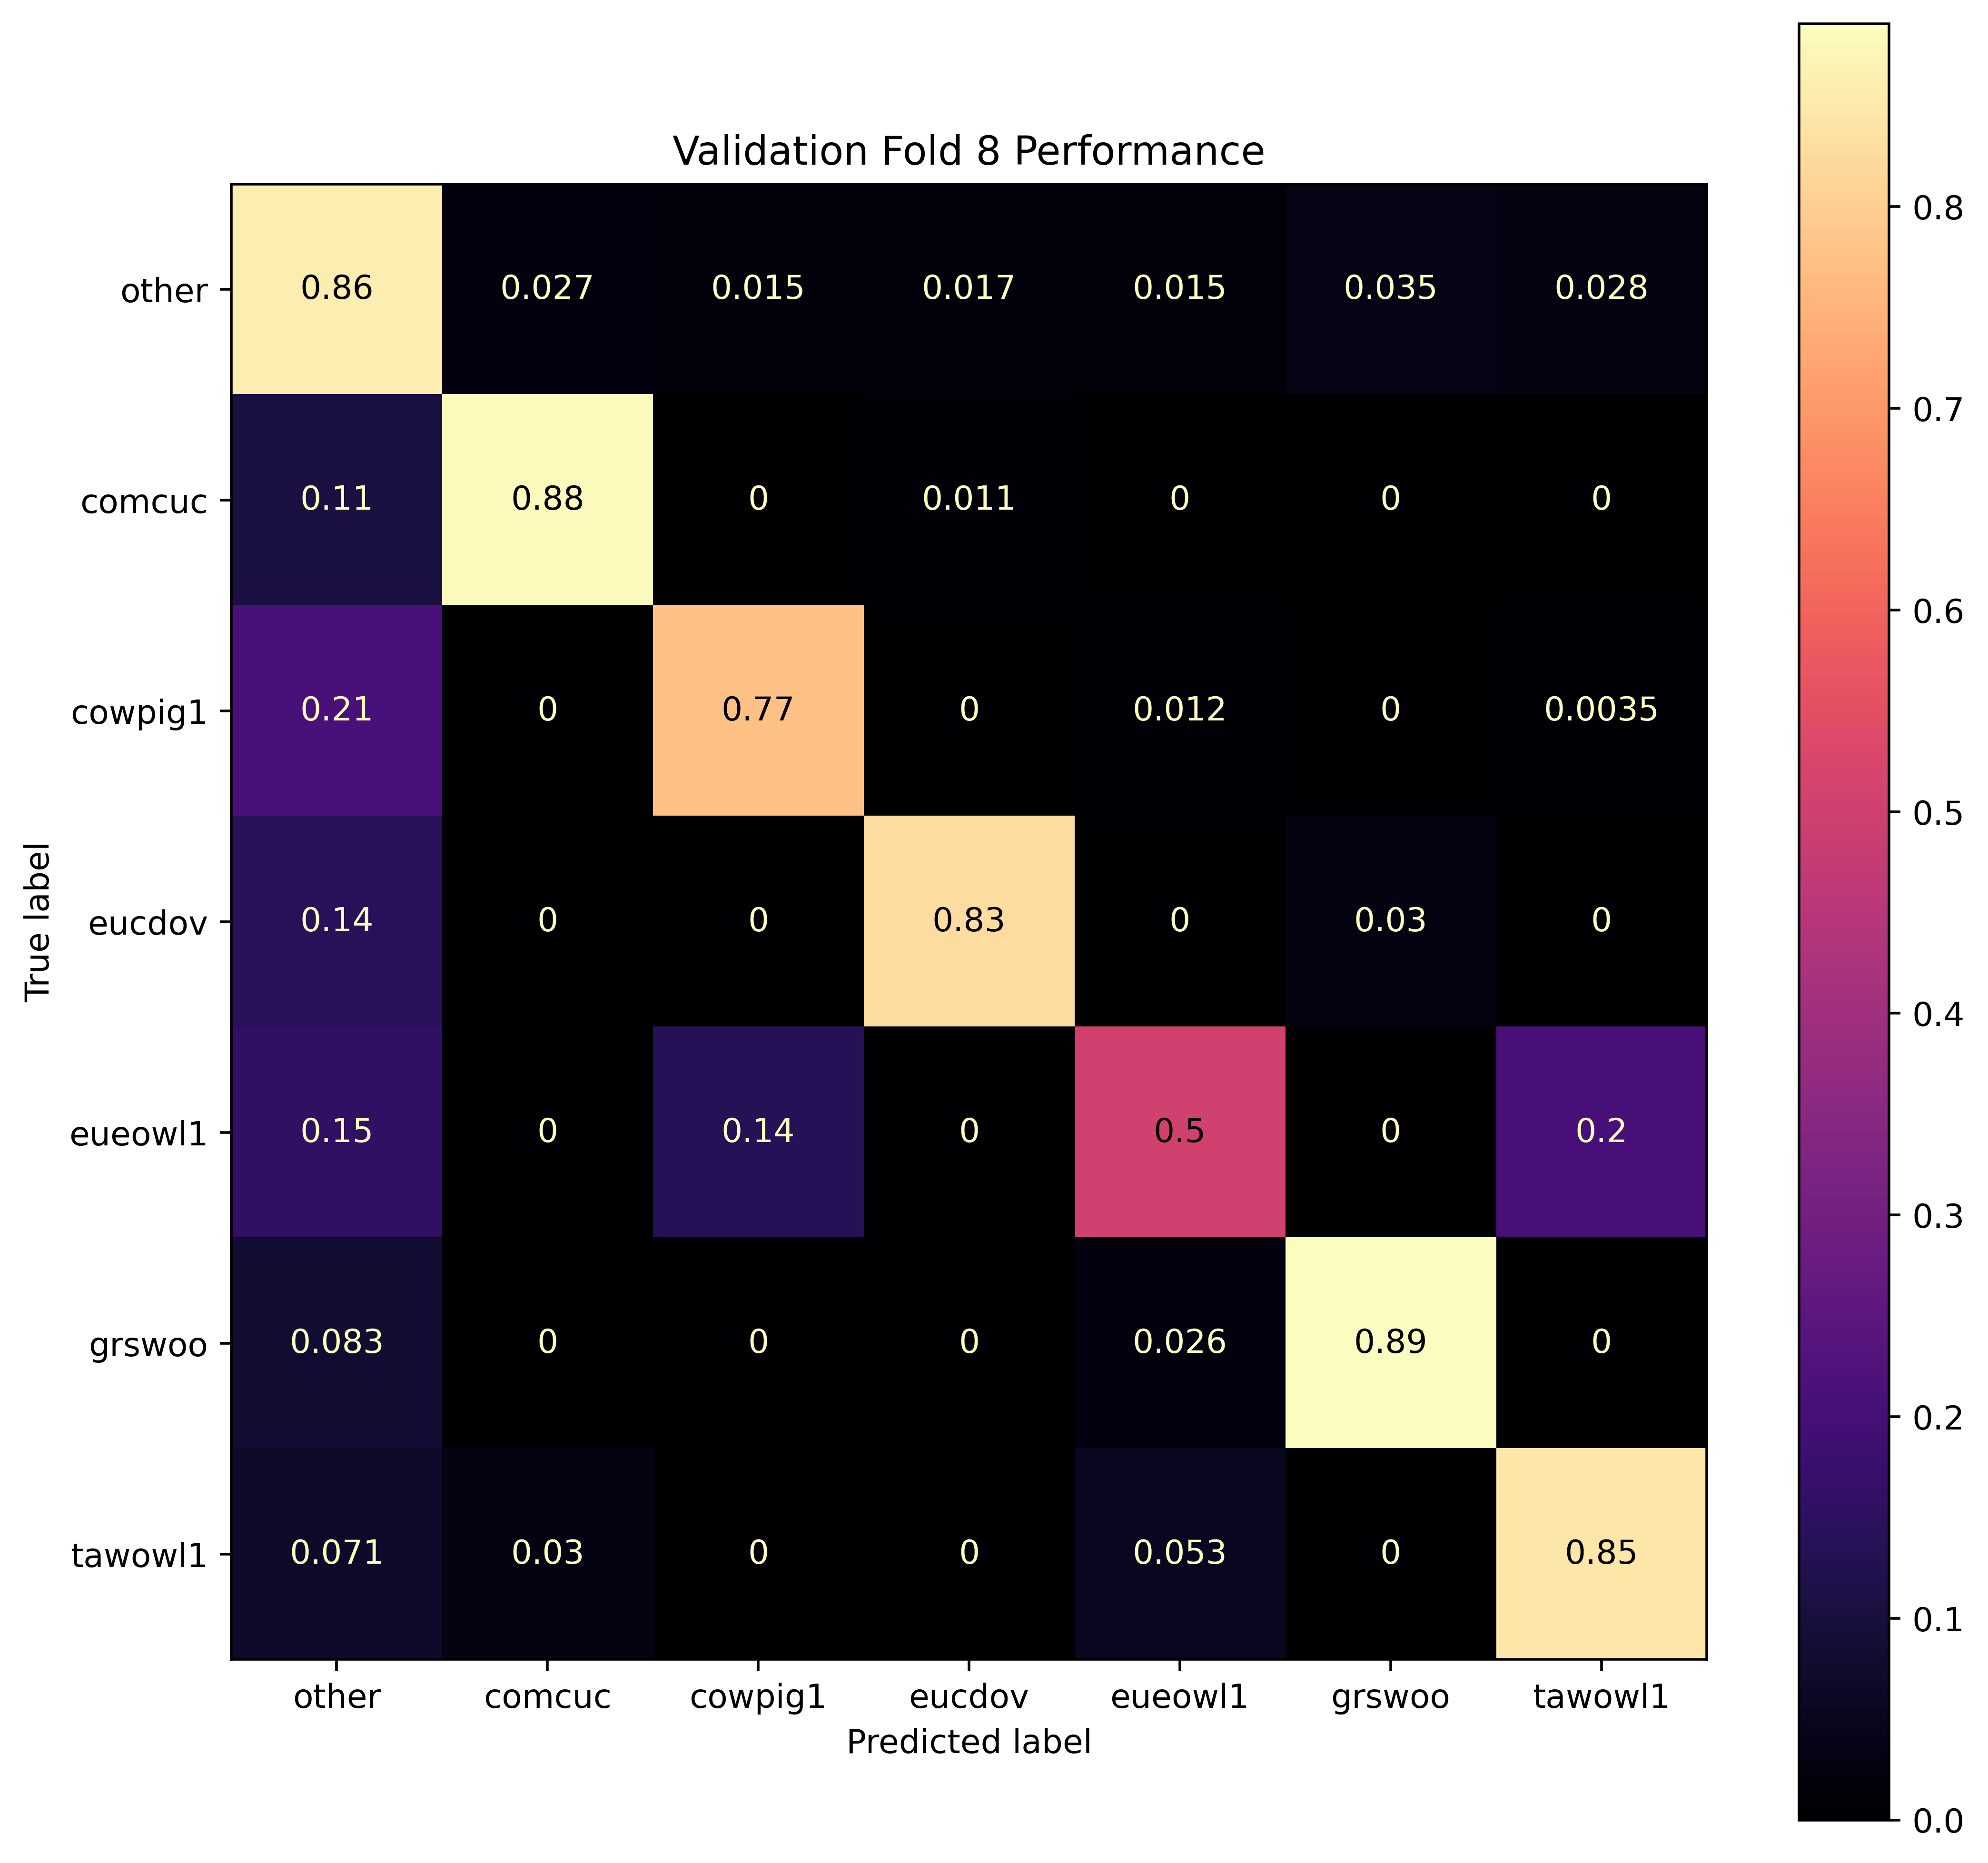

Saved model with scaler as "attention_classifier cv2023-05-18_21.34 fold-8"
Training fold 9
Training AttentionClassifier with 26739 parameters
loss_weight = tensor([ 1.0000, 15.2223,  9.4648, 10.3051, 37.4453, 18.2622, 19.2489],
       device='cuda:0')
Training Epoch   1/100: lr = 0.01, avg_loss = 0.000520, num_samples = 86400, num_correct =  6549, acc = 0.075799, bacc = 0.213659
Evaluation Epoch   1/100: avg_loss = 0.000493, num_samples =  9600, num_correct =  1381, acc = 0.143854, bacc = 0.342861
Training Epoch   2/100: lr = 0.01, avg_loss = 0.000399, num_samples = 86400, num_correct = 12396, acc = 0.143472, bacc = 0.405948
Evaluation Epoch   2/100: avg_loss = 0.000517, num_samples =  9600, num_correct =  2051, acc = 0.213646, bacc = 0.510944
Training Epoch   3/100: lr = 0.01, avg_loss = 0.000351, num_samples = 86400, num_correct = 16578, acc = 0.191875, bacc = 0.530660
Evaluation Epoch   3/100: avg_loss = 0.000479, num_samples =  9600, num_correct =  2155, acc = 0.224479, bacc = 0.6

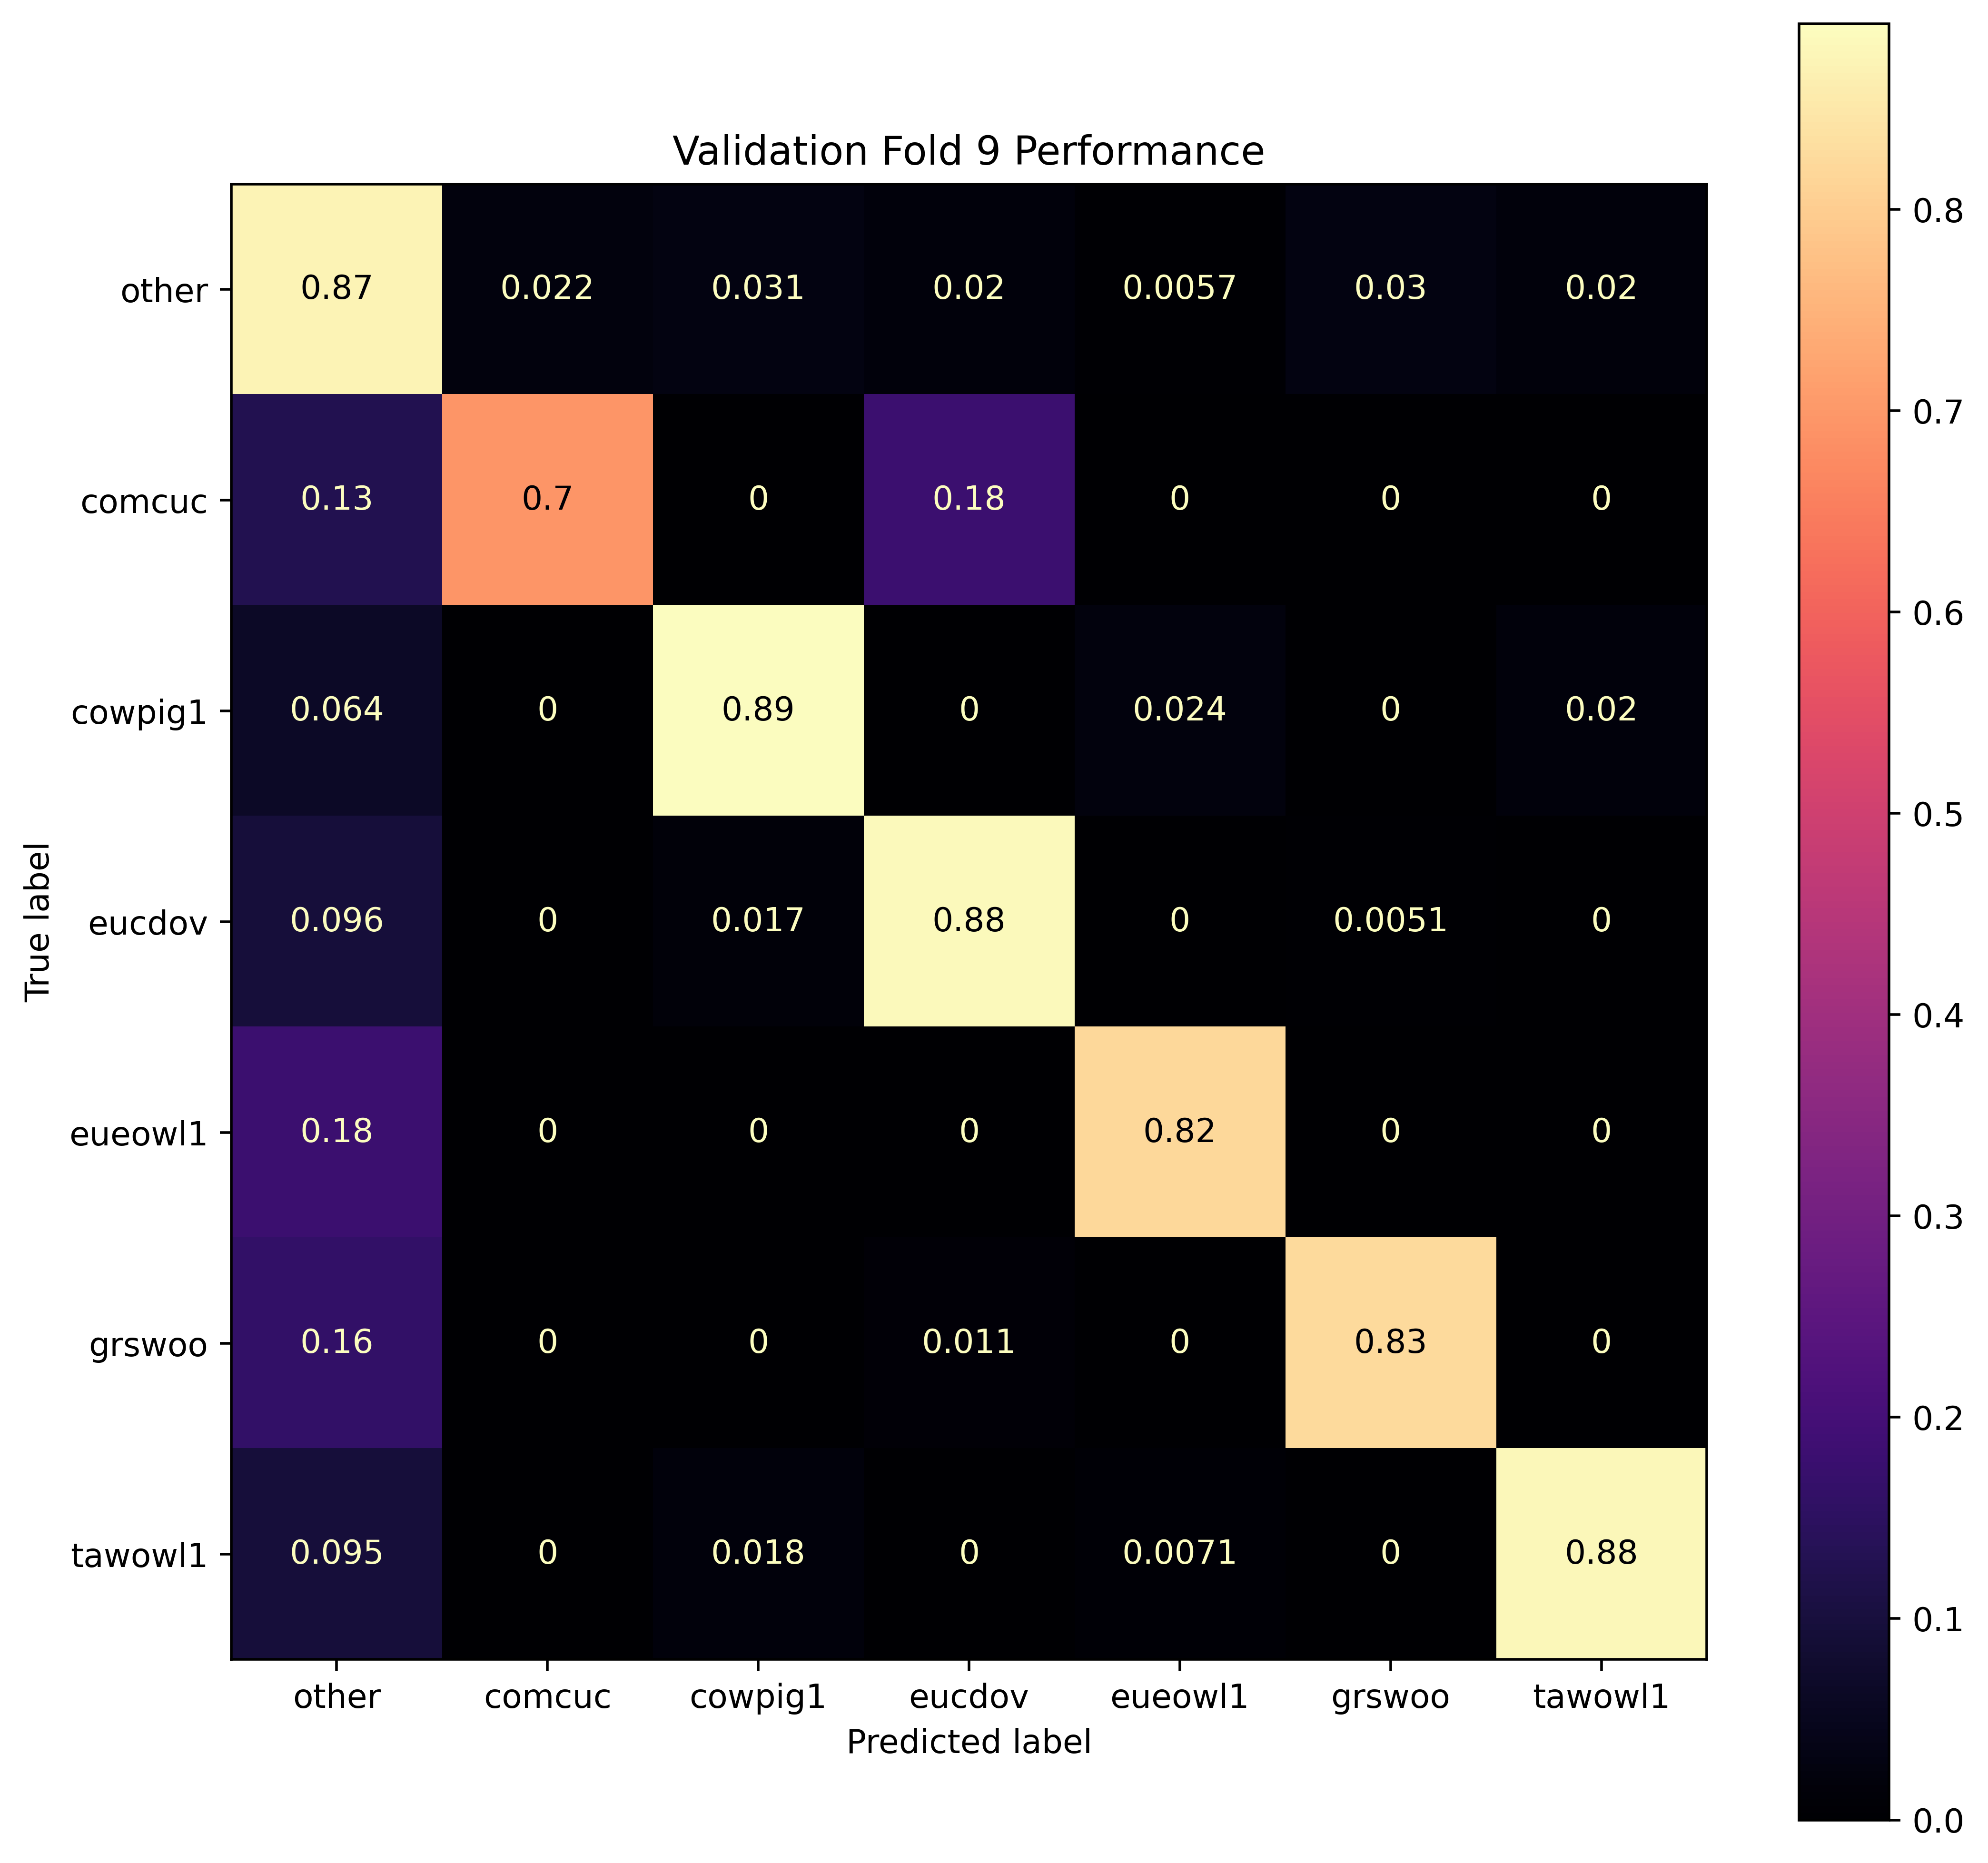

Saved model with scaler as "attention_classifier cv2023-05-18_21.34 fold-9"
cv_final_epoch_avg_train_metrics      = avg_loss = 0.000027, num_samples = 86400, num_correct = 77234, acc = 0.893912, bacc = 0.971468
cv_final_epoch_avg_evaluation_metrics = avg_loss = 0.003593, num_samples =  9600, num_correct = 7959.700000, acc = 0.829135, bacc = 0.817923


In [45]:
set_random_seed(42)

cv_training_hyper_parameters = create_training_hyper_parameters(1, 1)

cv_models_with_scalers, cv_folds_metrics = train_attention_classifier_with_cv(
    hyper_parameters, 
    cv_training_hyper_parameters, 
    NumpyDataset(data_train, labels_train),
    device,
    cv_folds_permute_seed=42
)


## Metrics ##

cv_final_epoch_avg_train_metrics, cv_final_epoch_avg_evaluation_metrics = calculate_average_metrics_for_final_epoch_of_folds(cv_folds_metrics)
print(f'{cv_final_epoch_avg_train_metrics      = }')
print(f'{cv_final_epoch_avg_evaluation_metrics = }')

cv_avg_epoch_train_metrics = calculate_average_metrics_per_epoch(cv_folds_metrics)

rows = []
for fold_nr, fold_metrics in enumerate(cv_folds_metrics):
    for epoch_nr, (train_metrics, eval_metrics) in enumerate(fold_metrics):
        rows.append({
            'cv_fold': fold_nr,
            'epoch': epoch_nr,
            'type': 'CV Train BACC',
            'bacc': train_metrics.bacc,
        })
        if eval_metrics is not None:
            rows.append({
                'cv_fold': fold_nr,
                'epoch': epoch_nr,
                'type': 'CV Eval BACC',
                'bacc': eval_metrics.bacc,
            })

cv_metrics_df = pd.DataFrame(rows)

## Final Train/Test

In [54]:
set_random_seed(42)

final_training_hyper_parameters = create_training_hyper_parameters(2, 0.5)

data_train_normalized, data_test_normalized, normalization_scaler = normalize_data(data_train, data_test)

attention_classifier, training_run_metrics = train_attention_classifier(
    hyper_parameters, 
    final_training_hyper_parameters, 
    NumpyDataset(data_train_normalized, labels_train),
    NumpyDataset(data_test_normalized, labels_test),
    device
)

test_loader = create_data_loader(data_test_normalized, labels_test)
test_metrics = evaluate_attention_classifier(
    attention_classifier, 
    test_loader, 
    device, 
    show_confmat = True,
    confmat_title = 'Test Set Performance'
)

print(f'{training_run_metrics[-1][0] = }')
print(f'{test_metrics                = }')

Training AttentionClassifier with 26739 parameters
loss_weight = tensor([ 1.0000, 15.3204,  9.3547, 10.4259, 36.4963, 17.9374, 19.6462],
       device='cuda:0')
Training Epoch   1/200: lr = 0.005, avg_loss = 0.000679, num_samples = 96000, num_correct =  4202, acc = 0.043771, bacc = 0.141597
Evaluation Epoch   1/200: avg_loss = 0.000747, num_samples = 24000, num_correct =   737, acc = 0.030708, bacc = 0.142857
Training Epoch   2/200: lr = 0.005, avg_loss = 0.000708, num_samples = 96000, num_correct =  3527, acc = 0.036740, bacc = 0.024166
Evaluation Epoch   2/200: avg_loss = 0.000610, num_samples = 24000, num_correct =  1071, acc = 0.044625, bacc = 0.145682
Training Epoch   3/200: lr = 0.005, avg_loss = 0.000705, num_samples = 96000, num_correct =  8179, acc = 0.085198, bacc = 0.017066
Evaluation Epoch   3/200: avg_loss = 0.000603, num_samples = 24000, num_correct = 14715, acc = 0.613125, bacc = 0.148182
Training Epoch   4/200: lr = 0.005, avg_loss = 0.000659, num_samples = 96000, num_c

KeyboardInterrupt: 

# Plots

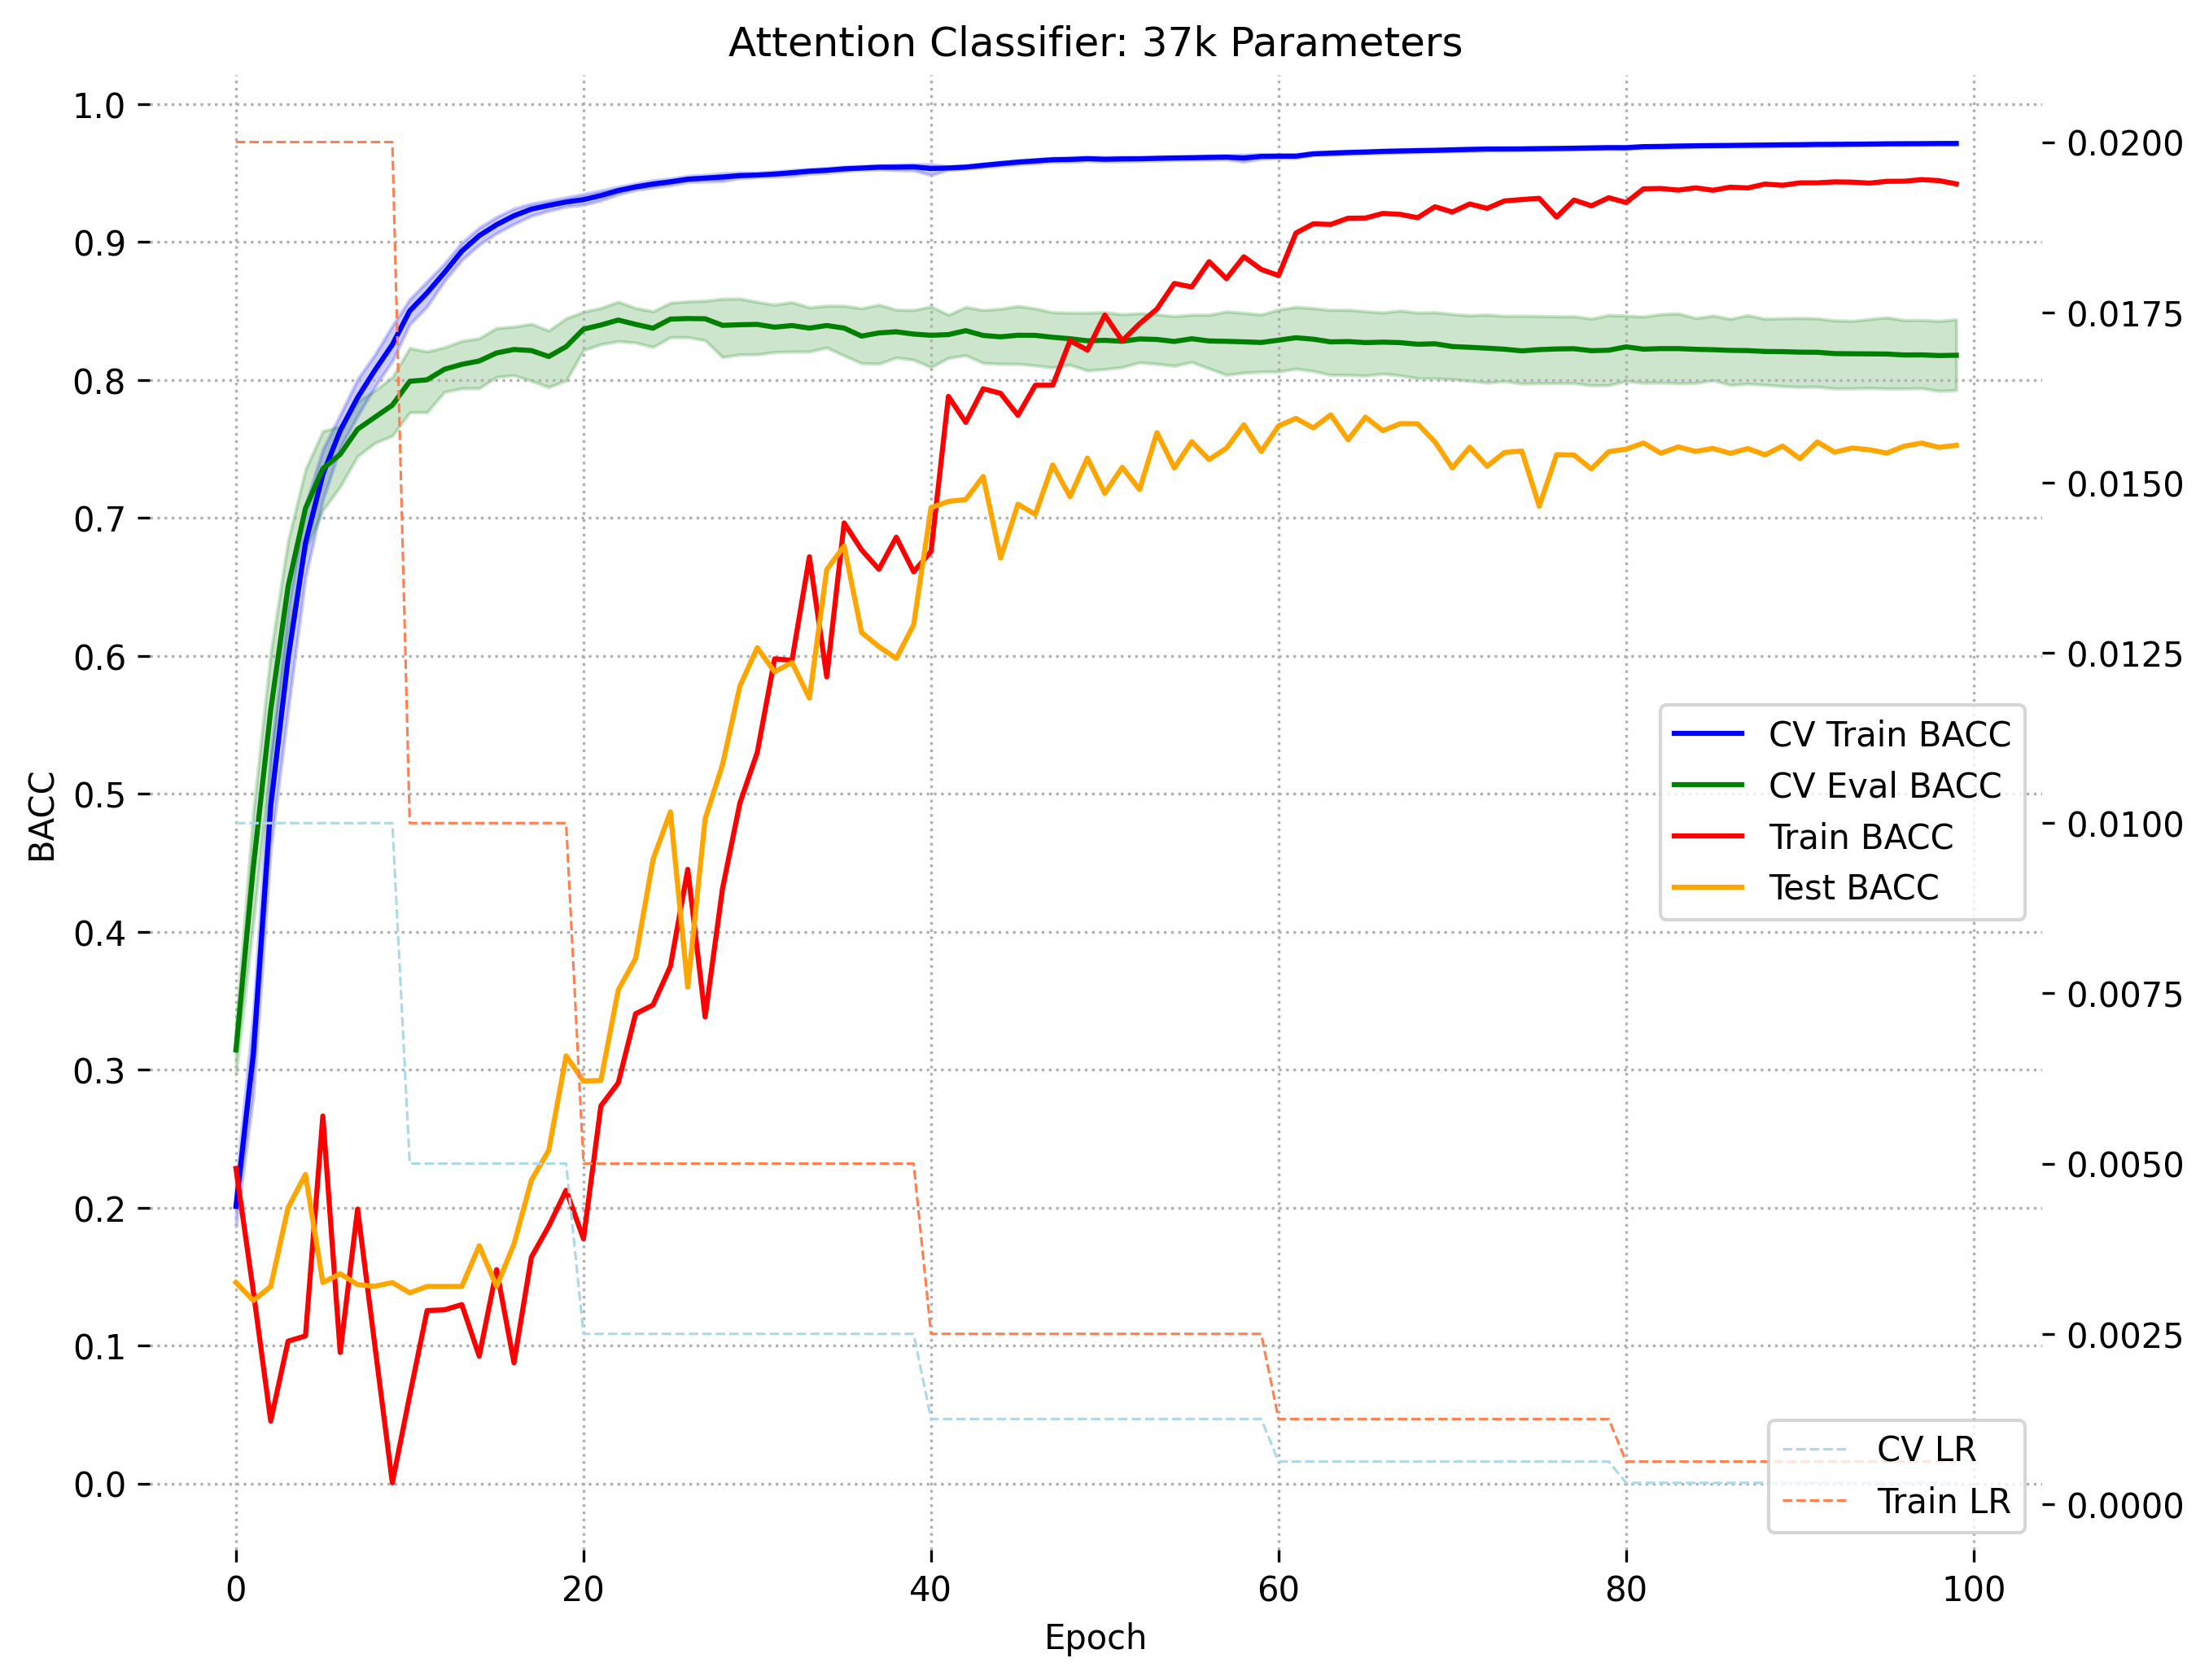

In [53]:
def create_lrs_over_epochs(training_hyper_parameters: TrainingHyperParameters) -> list[float]:
    lrs: list[float] = []
    
    lr = training_hyper_parameters.lr
    for epoch_nr in range(training_hyper_parameters.num_epochs):
        if epoch_nr in training_hyper_parameters.lr_scheduler_milestones:
            lr *= training_hyper_parameters.lr_scheduler_gamma
        lrs.append(lr)
    return lrs
    

def plot_baccs_over_epochs(title: str):
    fig, ax = plt.subplots(1, 1, figsize=(10, 8), dpi=300)
    
    cv_epoch_range = np.arange(0, cv_training_hyper_parameters.num_epochs)
    final_train_epoch_range = np.arange(0, final_training_hyper_parameters.num_epochs)
    
    sns.lineplot(data=cv_metrics_df, x='epoch', y='bacc', hue='type', ax=ax, palette=['blue', 'green'])

    ax.plot(final_train_epoch_range, list(map(lambda m: m[0].bacc, training_run_metrics)), label='Train BACC', c='red')
    ax.plot(final_train_epoch_range, list(map(lambda m: m[1].bacc, training_run_metrics)), label='Test BACC', c='orange')
    
    twin_ax = ax.twinx()
    lr_plots_kwargs = {
        'ls': '--',
        'lw': 0.75
    }
    twin_ax.plot(cv_epoch_range, create_lrs_over_epochs(cv_training_hyper_parameters), label='CV LR', c='lightblue', **lr_plots_kwargs)
    twin_ax.plot(final_train_epoch_range, create_lrs_over_epochs(final_training_hyper_parameters), label='Train LR', c='coral', **lr_plots_kwargs)

    ax.set(
        title=title,
        xlabel='Epoch',
        ylabel='BACC',
        yticks=[x * 0.1 for x in range(11)]
    )

    ax.grid(ls=':')
    ax.legend(loc='center right')
    twin_ax.legend(loc='lower right')

    for spine in ['top', 'right', 'bottom', 'left']:
        ax.spines[spine].set_visible(False)
        twin_ax.spines[spine].set_visible(False)

    plt.show()

plot_baccs_over_epochs('Attention Classifier: 37k Parameters')